In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 15.5,
                     'axes.titlepad': 25,
                     'axes.labelpad': 20,
                     'axes.labelsize': 20,
                     'xtick.labelsize' : 15.5,
                     'ytick.labelsize' : 15.5,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 1.5,
                     'lines.markersize': 5,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 100.0,
                     'figure.figsize': [8, 5],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.major.size': 8,
                     'ytick.minor.size': 4,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.5})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "20-PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["50-0"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
results_folder = "results20"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5] # ignore data of these frequencies
def extract_interpolate_and_derivative(data, num_points=0):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    # set initial time to 0 or to time of first full spectrum
    initial_test_t = 0
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
        
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]

        er_int_k = np.interp(t_test_set, t_k, er_k, left=np.nan, right=np.nan)
        ei_int_k = np.interp(t_test_set, t_k, ei_k, left=np.nan, right=np.nan)
        
        er_int.append(er_int_k)
        ei_int.append(ei_int_k)

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# edit this section to change fit function

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return A*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{P2}$ [rad/s]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{P3}$ [rad/s]",
            "$\\Delta\\epsilon_1$", "$\\alpha_1$", "$\\omega_{P1}$ [rad/s]"]
p_file_labels = ["de2", "a2", "w2",
                "de3", "a3", "w3",
                "de1", "a1", "w1"]

# starting initial guess for every run
p0_start = [
    # 70 (C-N-C-N)
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    # 50 (N-C-N)
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    [0.7483, 1., 1e3, 0.1884, 0.3615, 10000.0, 13990000.0, 1.0, 3.643e-08],
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    # 30 (N-C-N-C-N)
    [0.0934, 0.7863, 1841.0, 0.1127, 0.5849, 186300.0, 16.14, 0.5487, 0.007909],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06]]

# boundaries
i_ = np.inf
wi1, wf1 = 1e-2, 2e3
wi2, wf2 = 1., 1e7
wi3, wf3 = 0., 3e-1
bounds = ([0., 0., wi1, 0., 0., wi2, 0., 0., wi3], [i_, 1., wf1, i_, 1., wf2, i_, 1., wf3])

# fit functions with three cole-cole terms
def der_real (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) + CC_R(w, de_3, a_3, wp_3) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) + CC_I(w, de_3, a_3, wp_3) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3), 
            imag(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    # calculate the individual terms (set right parameter positions and functions)
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:6])
    x3_ = CC_R(w_, *popt[6:])
    # plot the terms
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')
    ax1.plot(w_, x3_, linestyle=':', color='black')
    # label with a number
    ax1.text(popt[2], popt[0]/12, "(ii)", color='red', fontsize=17)
    ax1.text(popt[5], max(popt[3]/16, 1e-2), "(iii)", color='blue', fontsize=17)
    if np.any(x3_ > 1e-2) :
        ax1.text(5e-1, 5e-2, "(i)", color='black', fontsize=17)


In [ ]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(10), np.log(1e9), 1000)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        y = np.exp(der_real(lnw_area, *popt))
        a = np.trapezoid(y, lnw_area)
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            y = np.exp(der_real(lnw_area, *popt))
            a = np.trapezoid(y, lnw_area)
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

title_text = "BDS of  "

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
    ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
    ax1.set_ylabel("$\\log_{10}\\left(~~\\epsilon'_{der} ~~\\right)$") # = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])
    ax2.set_ylabel("$\\log_{10}\\left(~~\\epsilon'' ~~\\right)$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = title_text + SAMPLE_SHORT +'-'+ id + "  at  " + timestr
    plt.title(title)
    ax1.set_xlabel("$\\log_{10}\\left(~~\\omega~ [rad/s] ~~\\right)$")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.87))
    #plt.savefig(results_folder + "/fits/"+id+'-'+str(np.round(dt))+"min.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_40280/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


[2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 0.0, 1.0, 0.0]
0 0 IndexError :  index 0 is out of bounds for axis 0 with size 0
fit score 358180.0
fit parameters [2.603, 0.6629, 7.479, 0.1822, 0.4165, 148200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


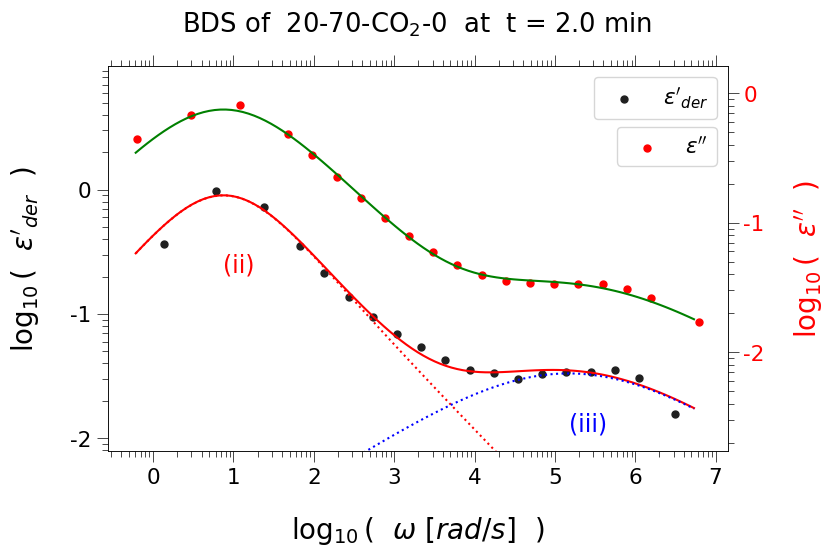

fit score 486472.0
fit parameters [2.593, 0.6659, 6.904, 0.1834, 0.4087, 140600.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


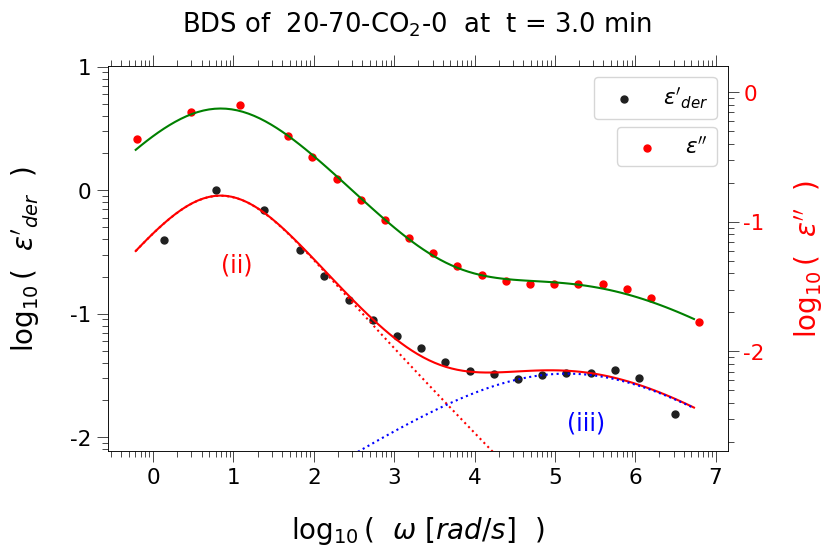

fit score 1327649.0
fit parameters [2.587, 0.67, 5.092, 0.1815, 0.3879, 120200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


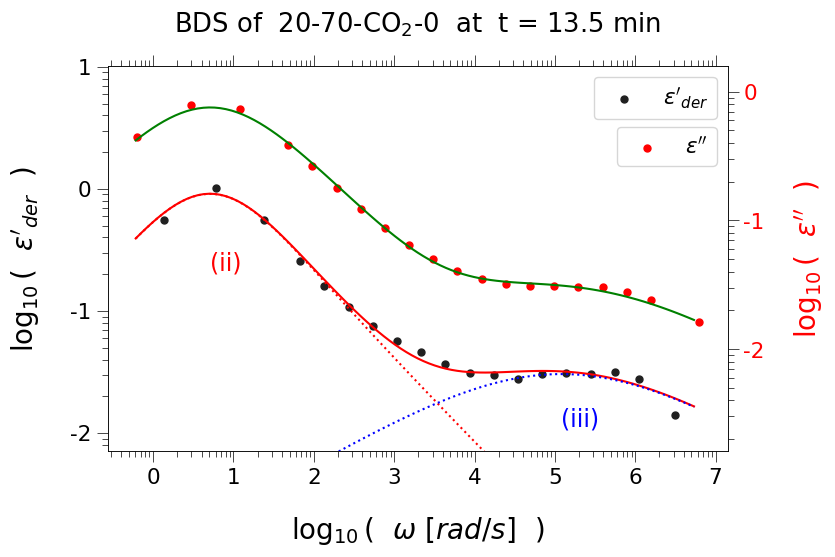

fit score 1659005.0
fit parameters [2.559, 0.6643, 4.414, 0.1727, 0.3877, 120200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


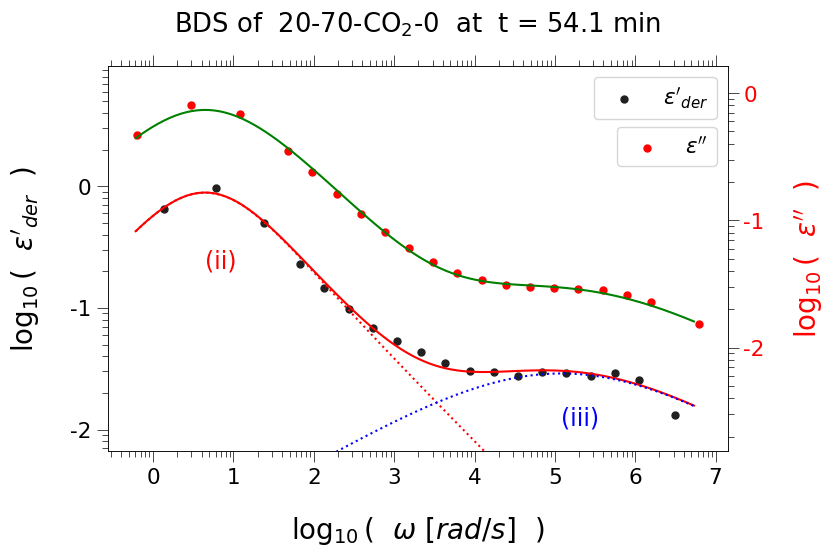

fit score 1601324.0
fit parameters [2.614, 0.6485, 3.65, 0.1622, 0.3968, 120200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


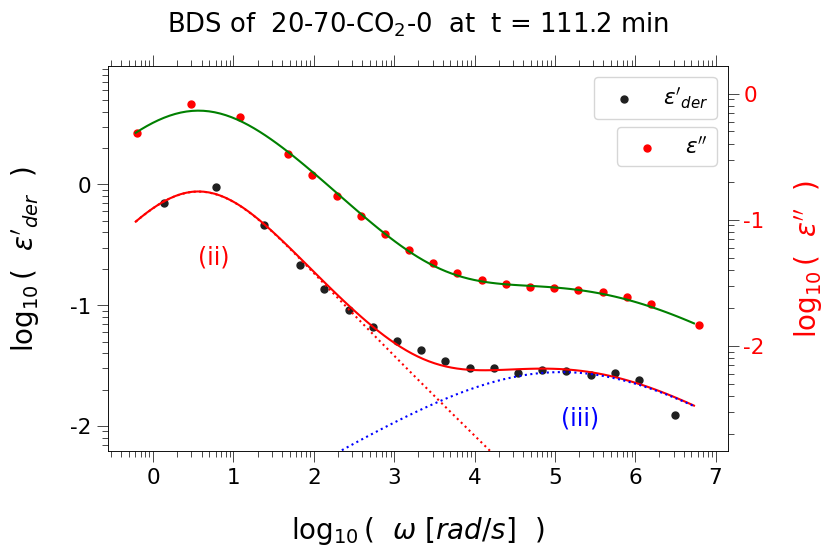

fit score 116608.0
fit parameters [2.188, 0.6895, 26.46, 0.1438, 0.4611, 226600.0, 4217000.0, 0.9055, 2.074e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


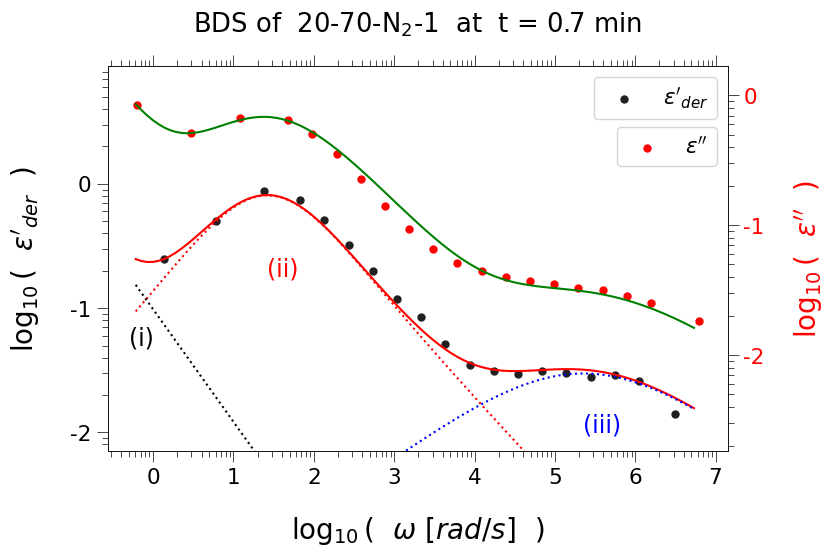

fit score 40090565.0
fit parameters [2.024, 0.7712, 227.4, 0.5696, 0.3114, 5814.0, 4613000.0, 0.8357, 2.834e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


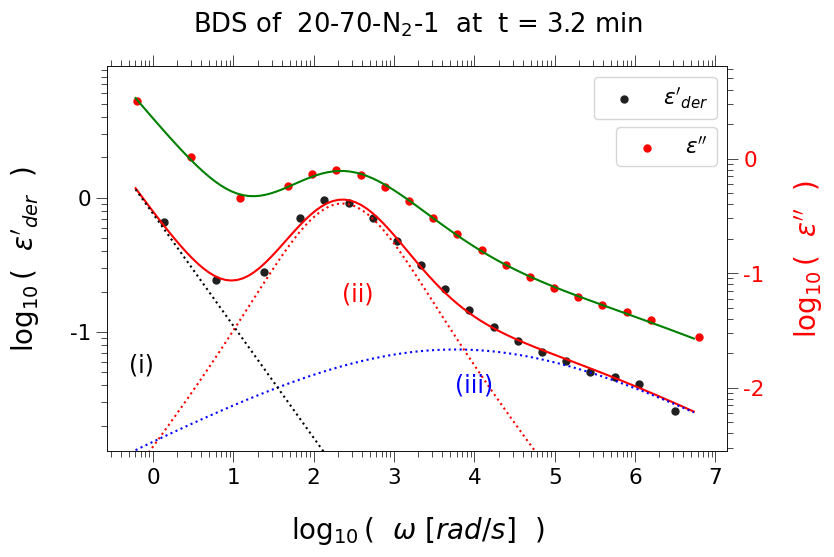

fit score 127773730.0
fit parameters [1.577, 0.7773, 510.8, 1.053, 0.3696, 4741.0, 20990000.0, 0.7946, 7.707e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


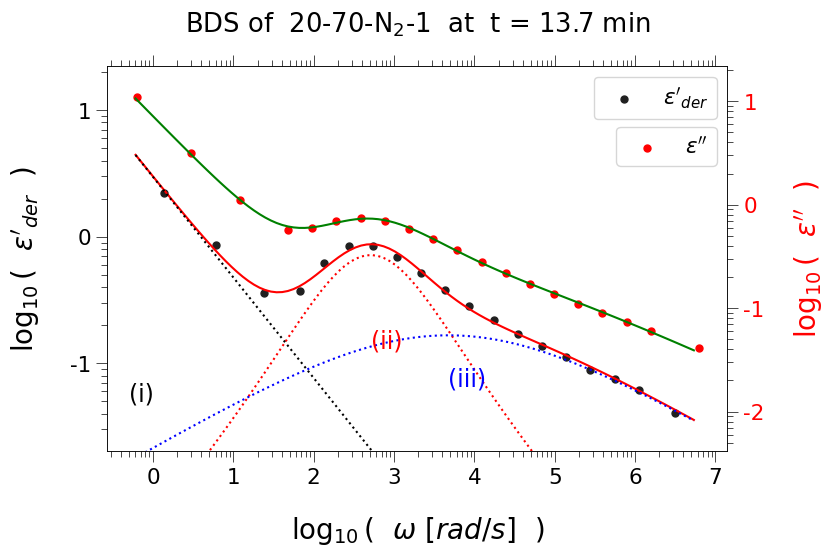

fit score 469682030.0
fit parameters [1.362, 0.7911, 781.3, 1.386, 0.3712, 5729.0, 37860000.0, 0.7741, 4.435e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


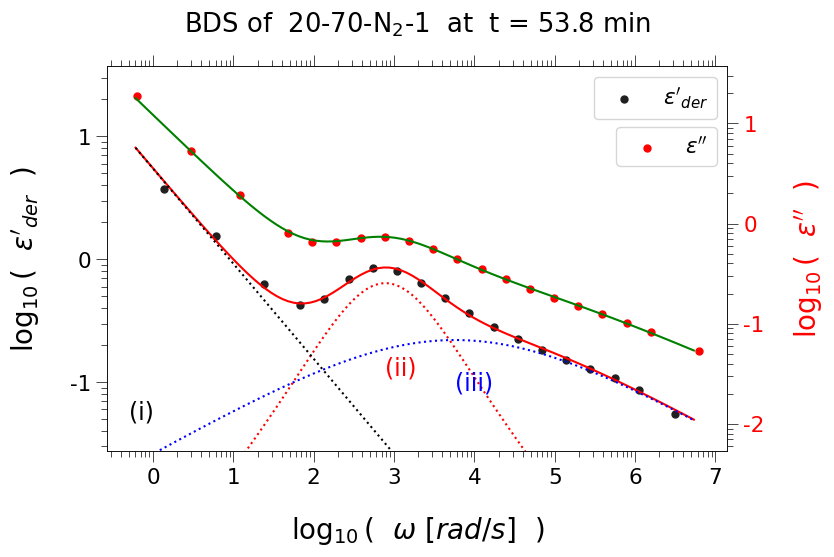

fit score 191276586.0
fit parameters [1.205, 0.812, 855.0, 1.62, 0.373, 3966.0, 41110000.0, 0.7626, 3.25e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


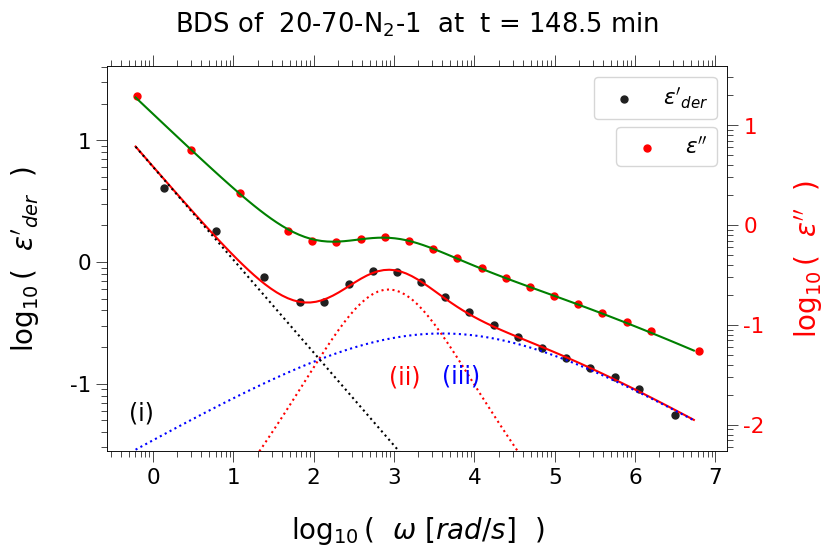

FALLBACK 1:  46973.0
fit score 46973.0
fit parameters [2.59, 0.6433, 9.536, 0.1878, 0.4151, 240400.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


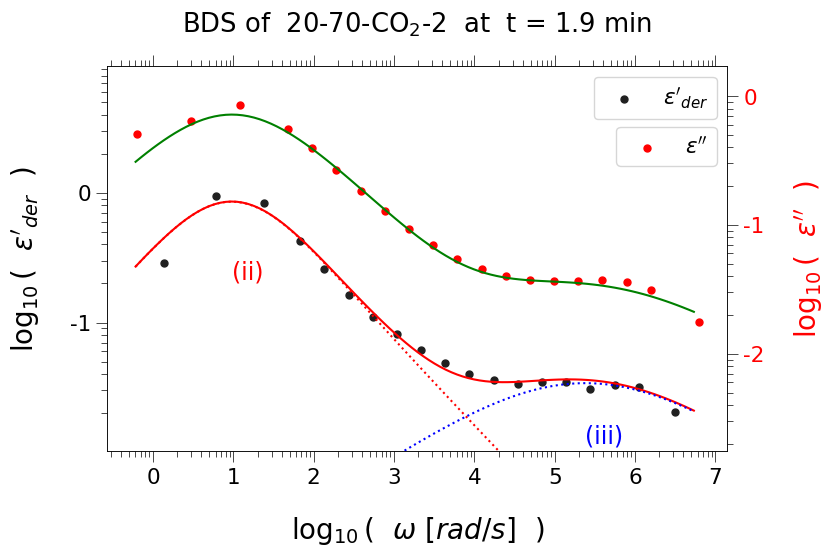

fit score 184917.0
fit parameters [2.693, 0.6615, 6.921, 0.176, 0.4348, 133100.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


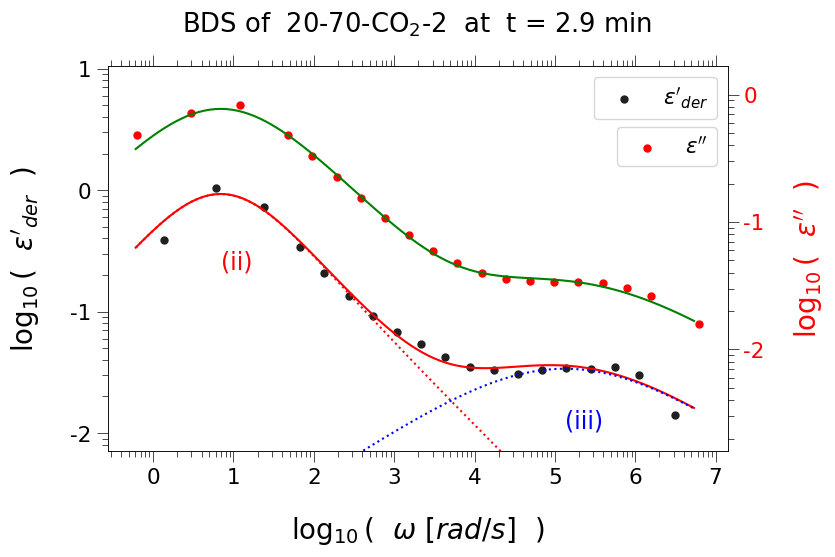

fit score 668585.0
fit parameters [2.698, 0.6592, 3.881, 0.1639, 0.4223, 111200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


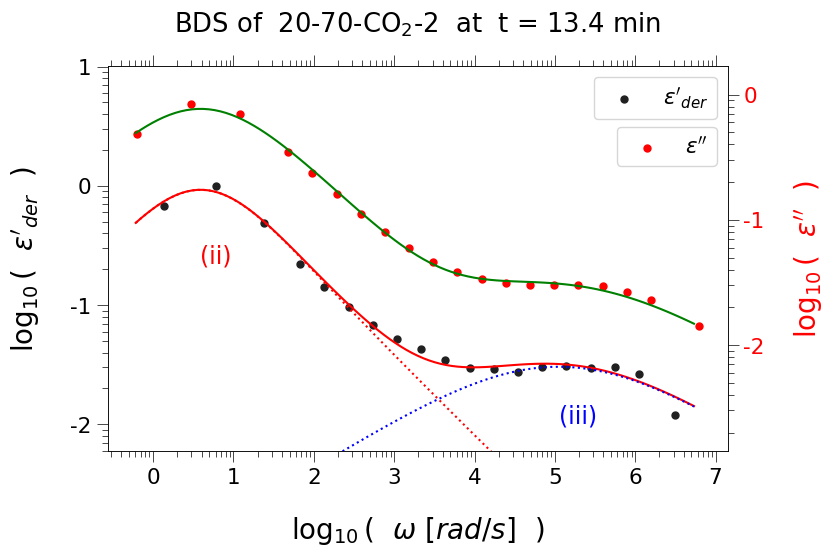

fit score 946494.0
fit parameters [2.689, 0.6487, 3.518, 0.1574, 0.4198, 111200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


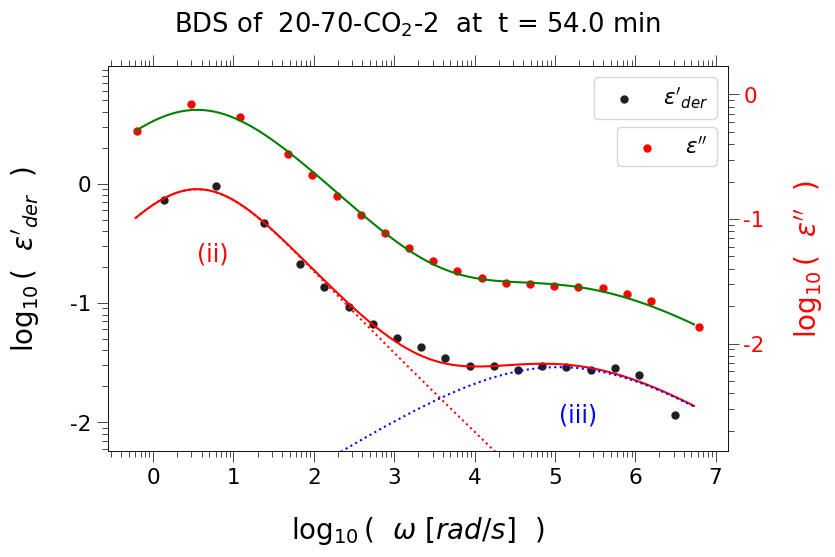

fit score 545107.0
fit parameters [2.749, 0.6317, 2.933, 0.146, 0.4291, 111200.0, 1e-10, 1.0, 1e-10]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


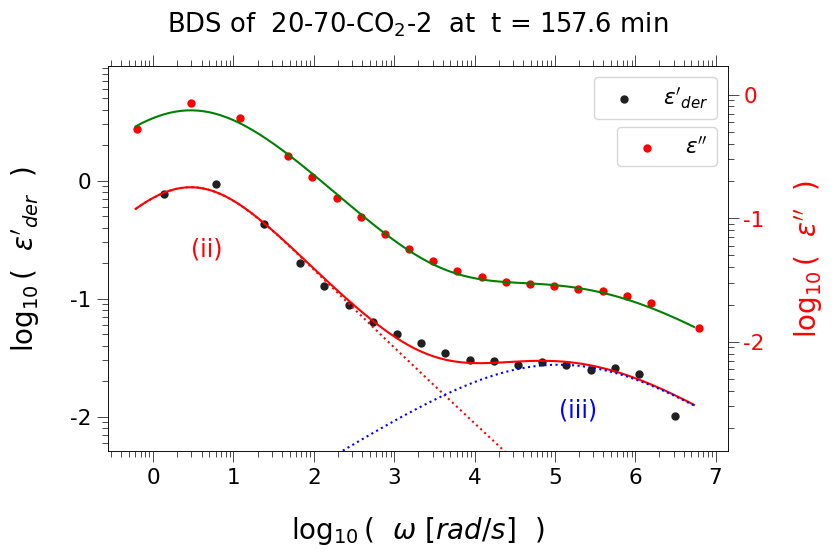

FALLBACK 1:  3.0
fit score 39526.0
fit parameters [2.786, 0.4756, 10.83, 0.3994, 0.1435, 35310.0, 277700.0, 0.7495, 9.278e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


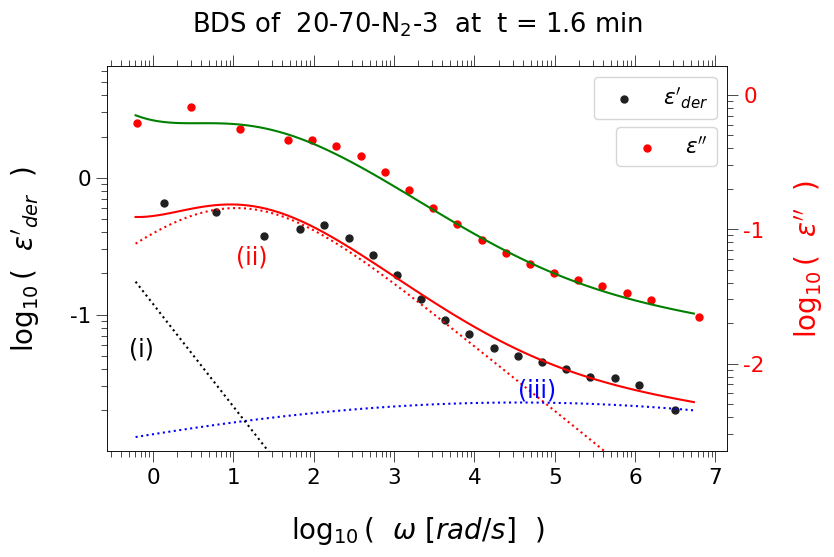

fit score 50610336.0
fit parameters [2.074, 0.753, 166.8, 0.5507, 0.2827, 4752.0, 670200.0, 0.8169, 1.273e-07]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


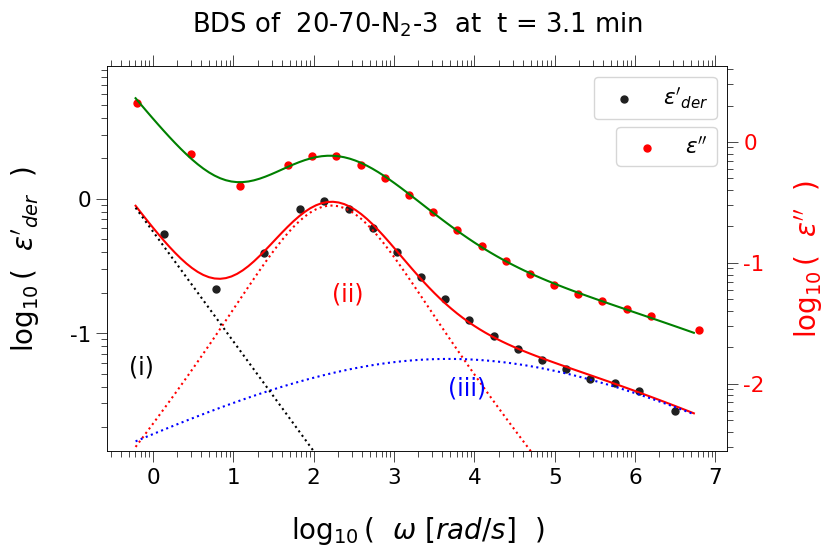

fit score 146239679.0
fit parameters [1.588, 0.7637, 465.3, 1.052, 0.3545, 3860.0, 2396000.0, 0.7315, 1.862e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


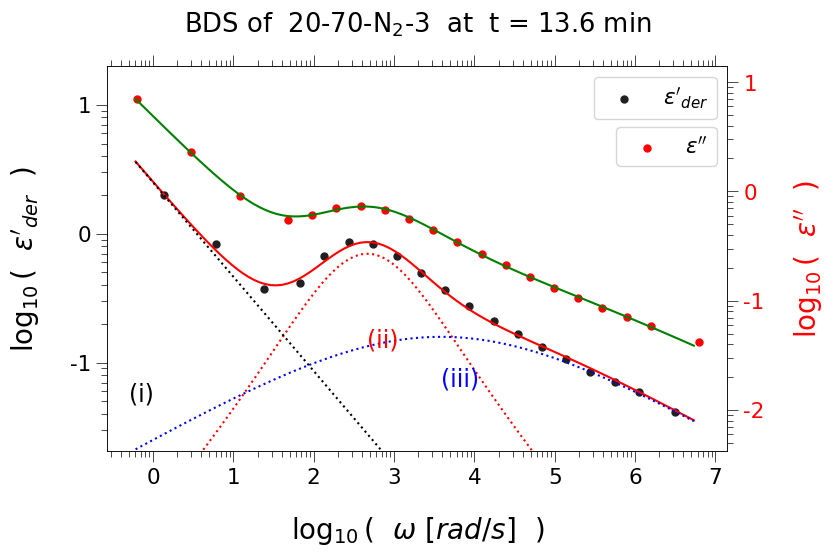

fit score 968778879.0
fit parameters [1.355, 0.789, 753.3, 1.403, 0.3641, 5275.0, 9993000.0, 0.7383, 8.065e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


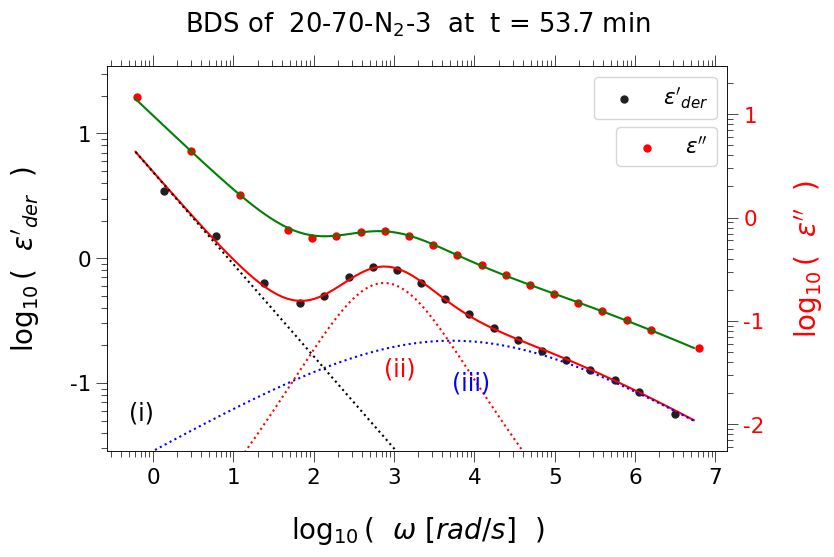

fit score 404278276.0
fit parameters [1.246, 0.8044, 886.2, 1.584, 0.3682, 4409.0, 15710000.0, 0.7435, 6.557e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


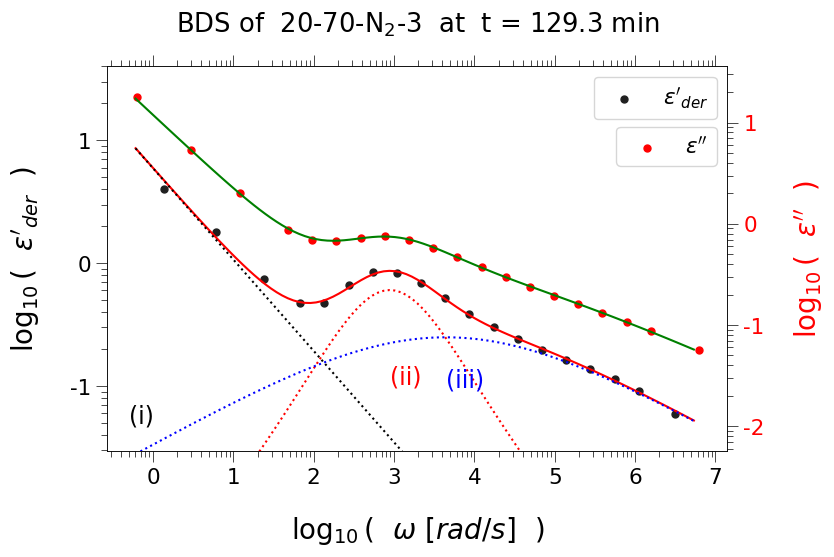

/tmp/ipykernel_40280/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)
/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


FALLBACK 1:  43395.0
fit score 43395.0
fit parameters [1.93, 0.6308, 8.653, 0.1726, 0.3646, 73790.0, 17540000.0, 1.0, 8.271e-09]


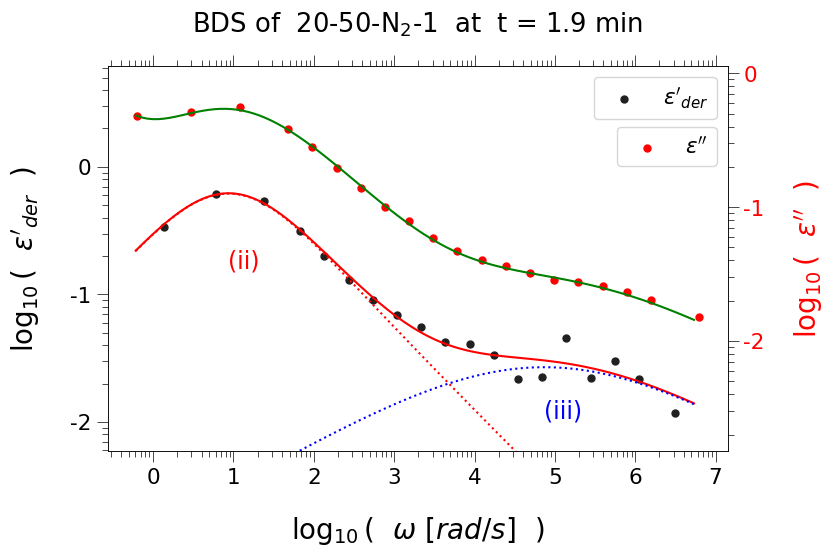

fit score 10278190.0
fit parameters [1.777, 0.7046, 13.15, 0.2776, 0.2881, 9939.0, 7011000.0, 1.0, 2.87e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


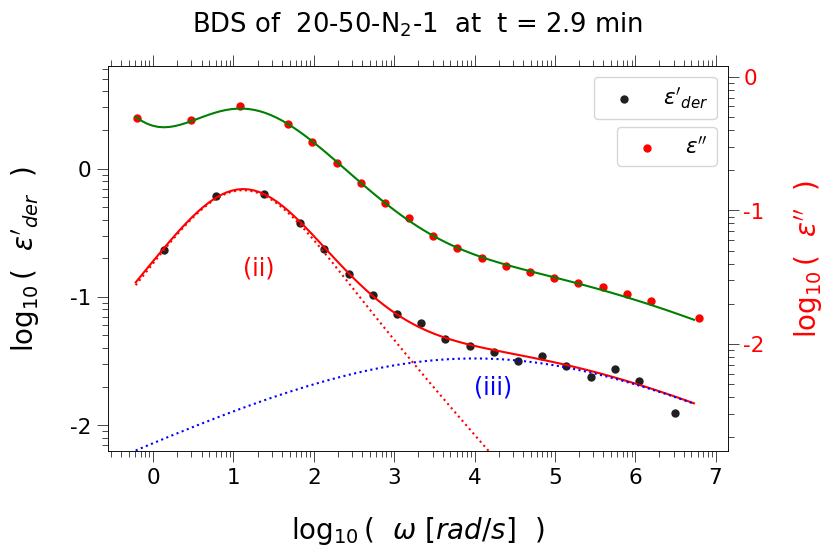

fit score 86848203.0
fit parameters [1.717, 0.7153, 27.14, 0.353, 0.2593, 5223.0, 57840000.0, 0.9802, 4.27e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


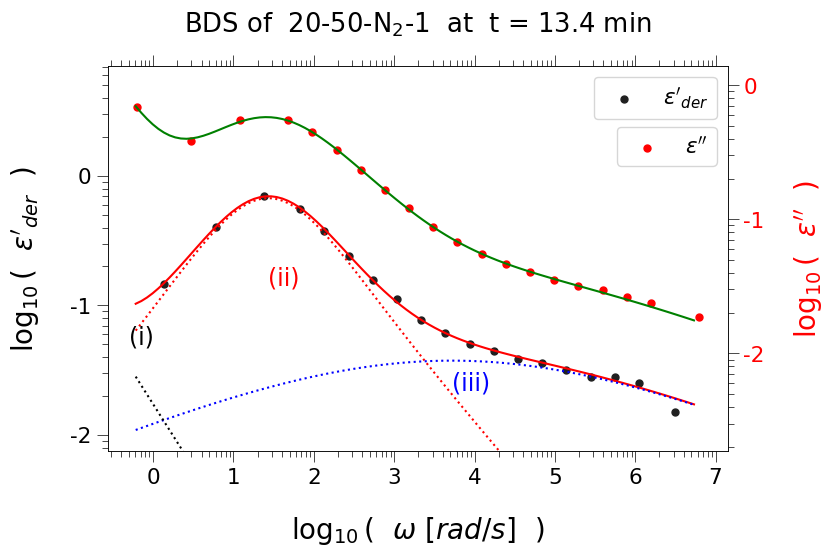

fit score 14145222.0
fit parameters [1.436, 0.7393, 87.27, 0.5962, 0.2725, 1490.0, 111300000.0, 0.8976, 1.048e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


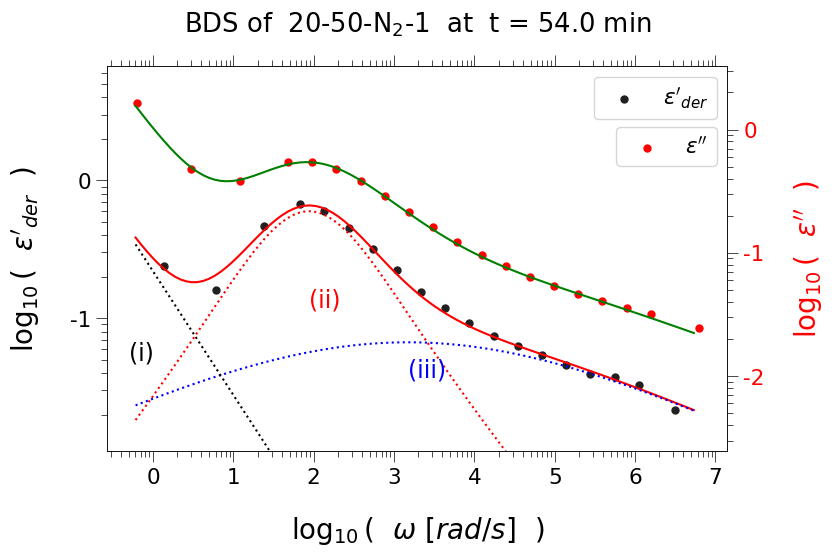

FALLBACK 1:  20660.0
fit score 1503960.0
fit parameters [1.339, 0.7499, 115.7, 0.6855, 0.3028, 1826.0, 60790000.0, 0.8607, 1.429e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


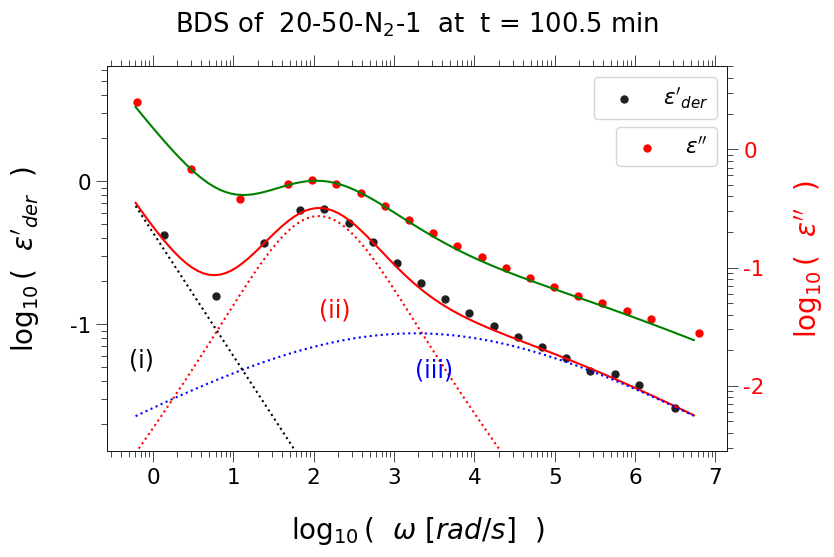

fit score 73988.0
fit parameters [0.2361, 0.7002, 101.3, 0.1369, 0.4283, 73320.0, 2233.0, 0.5238, 1.321e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


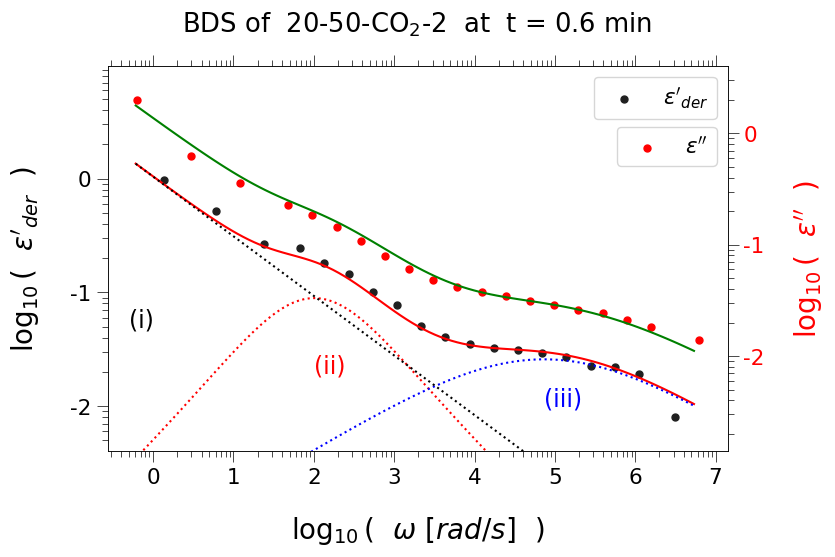

FALLBACK 2:  34310.0
fit score 60602.0
fit parameters [1.332e-06, 0.2772, 224.1, 0.1876, 0.3009, 8087.0, 4225.0, 0.4953, 6.211e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


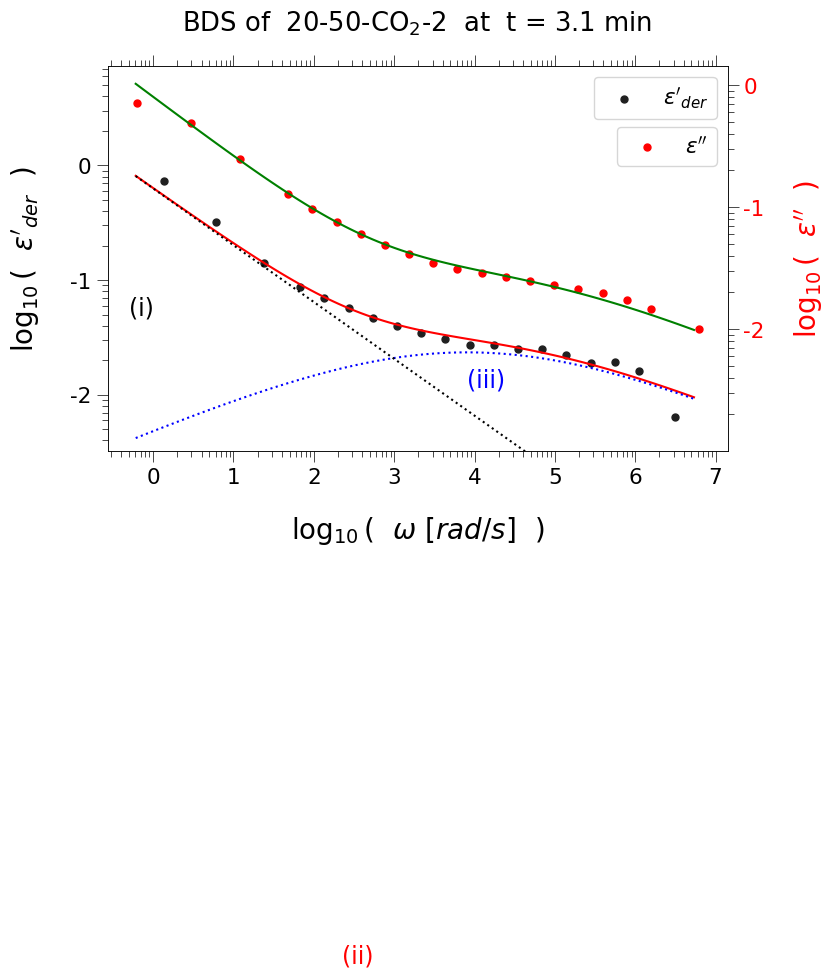

FALLBACK 2:  39192.0
fit score 290911.0
fit parameters [0.1384, 0.3274, 2000.0, 0.02667, 0.6665, 224500.0, 5311.0, 0.5186, 4.782e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


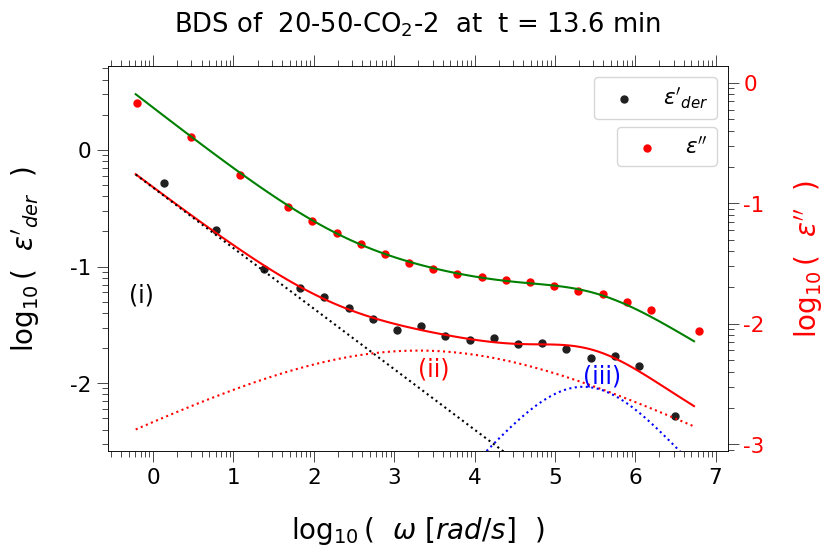

fit score 440357.0
fit parameters [0.1512, 0.313, 2000.0, 0.02335, 0.7144, 264200.0, 11070.0, 0.5411, 2.363e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


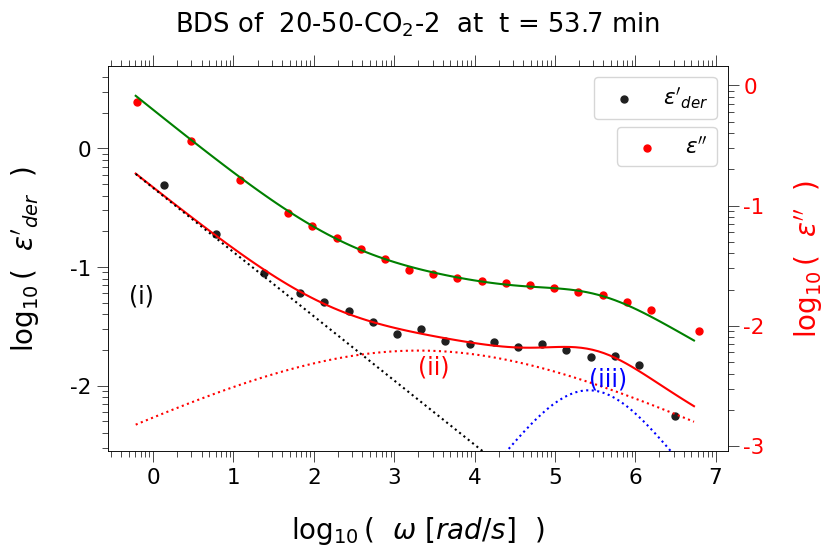

fit score 1068707.0
fit parameters [0.1583, 0.3058, 1985.0, 0.02144, 0.7476, 298300.0, 21690.0, 0.5528, 1.004e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


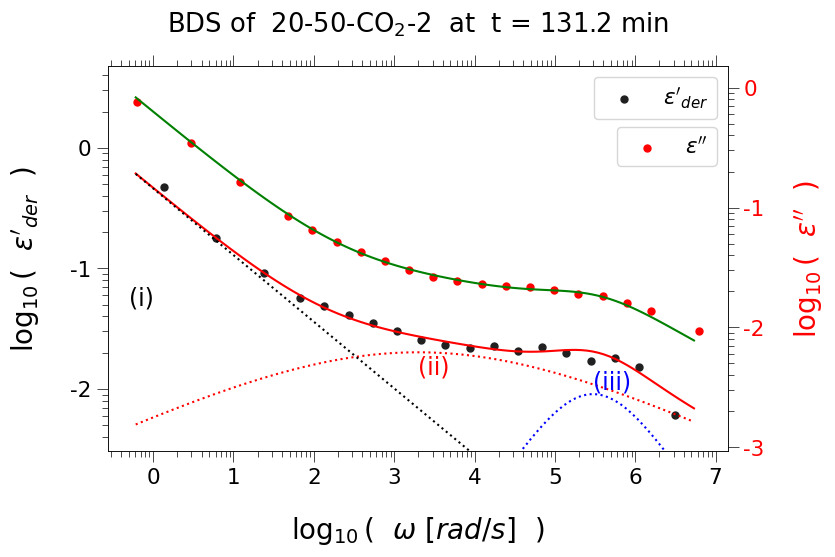

fit score 30919.0
fit parameters [0.9687, 0.7801, 11.85, 0.2676, 0.3039, 2680.0, 12180000.0, 1.0, 3.503e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


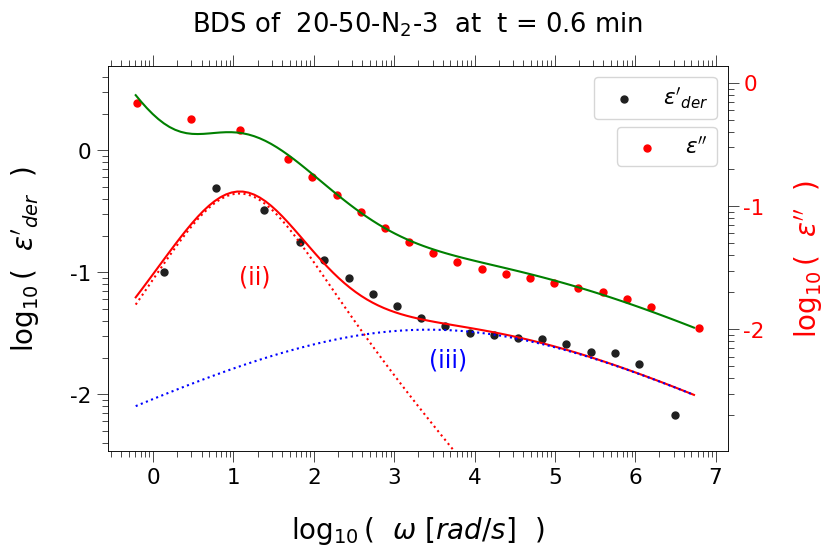

fit score 68079778.0
fit parameters [1.685, 0.7138, 13.24, 0.3057, 0.2666, 5400.0, 3190000.0, 1.0, 6.728e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


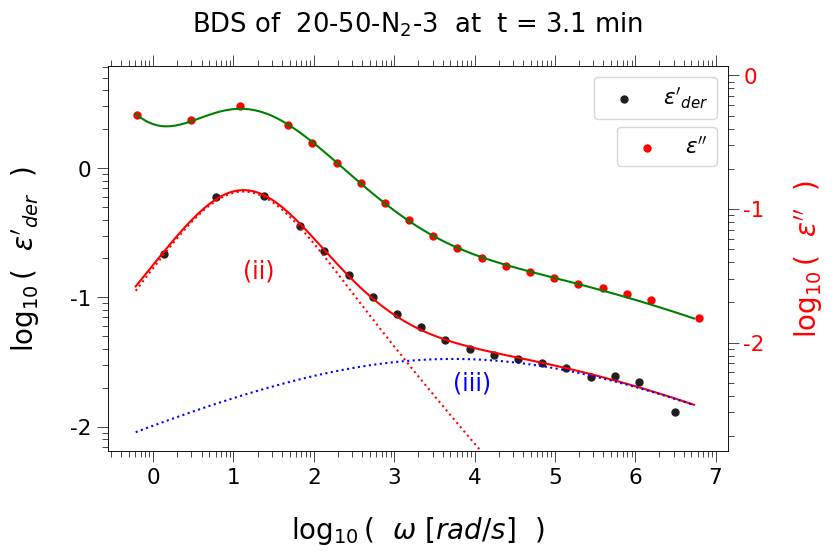

fit score 134401875.0
fit parameters [1.619, 0.7381, 25.2, 0.4162, 0.2369, 1468.0, 2168000.0, 1.0, 1.274e-07]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


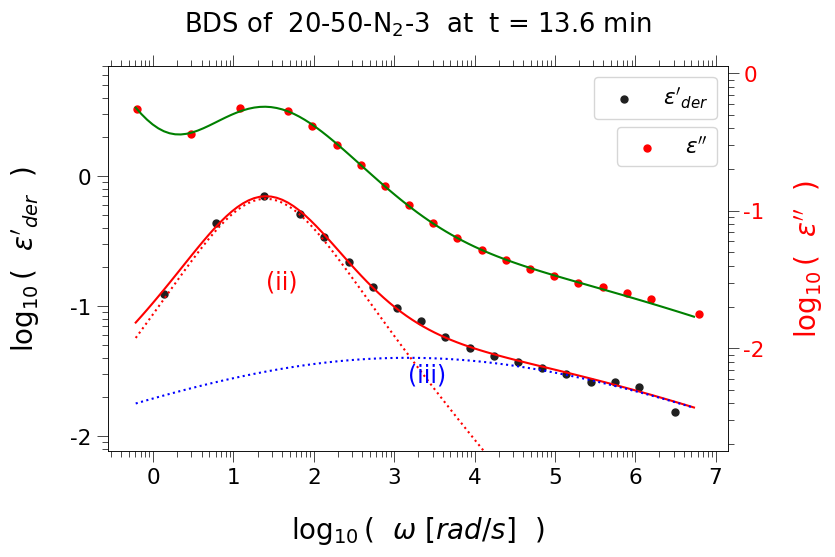

fit score 15152925.0
fit parameters [1.427, 0.7486, 79.42, 0.581, 0.2665, 1304.0, 29400000.0, 0.8896, 3.01e-09]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


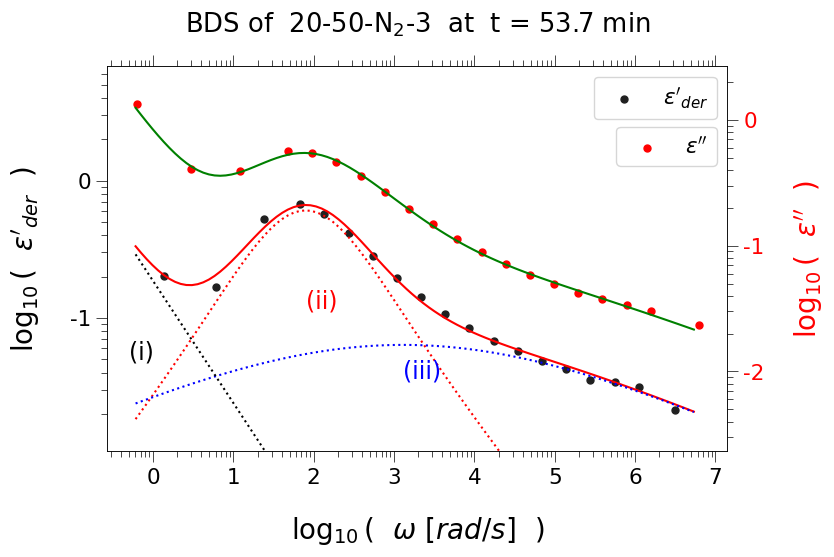

/tmp/ipykernel_40280/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)
/tmp/ipykernel_40280/3649991613.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')


FALLBACK 2:  nan
FALLBACK 1:  3957639260.0
fit score 3957639260.0
fit parameters [1.884, 0.5875, 17.15, 0.4325, 0.3657, 17560.0, 18.32, 0.9999, 0.05636]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


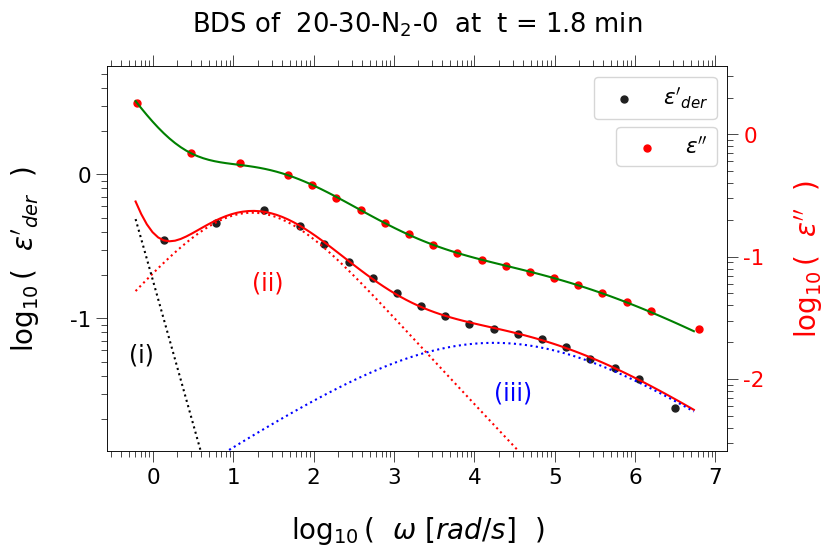

fit score 5675176493.0
fit parameters [1.902, 0.582, 19.06, 0.4184, 0.3725, 22760.0, 15.92, 1.0, 0.07477]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


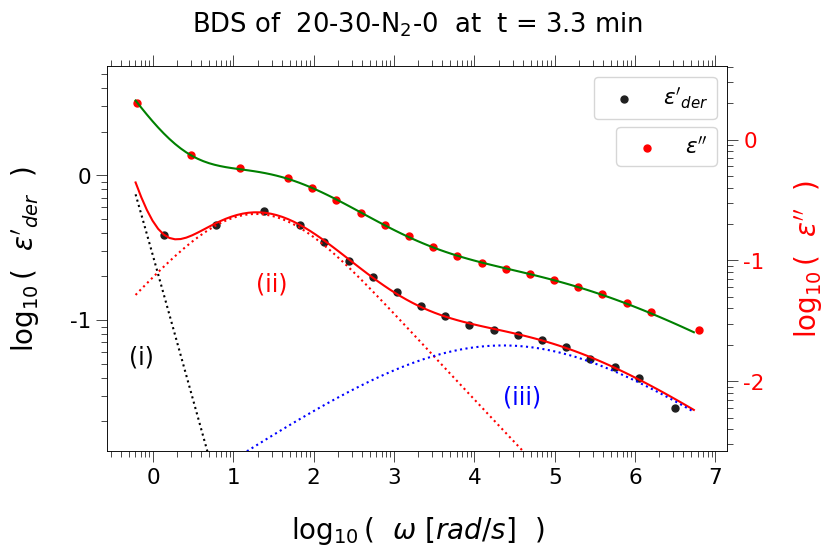

fit score 2960241833.0
fit parameters [1.902, 0.6052, 36.62, 0.4253, 0.3914, 41170.0, 13.96, 1.0, 0.1809]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


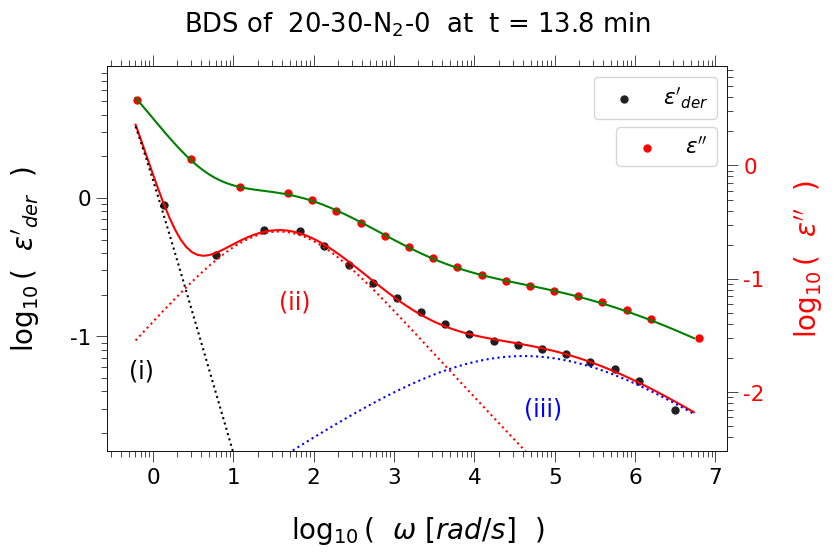

fit score 979336717.0
fit parameters [1.865, 0.6188, 68.45, 0.4045, 0.4106, 85520.0, 64.87, 0.9228, 0.06521]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


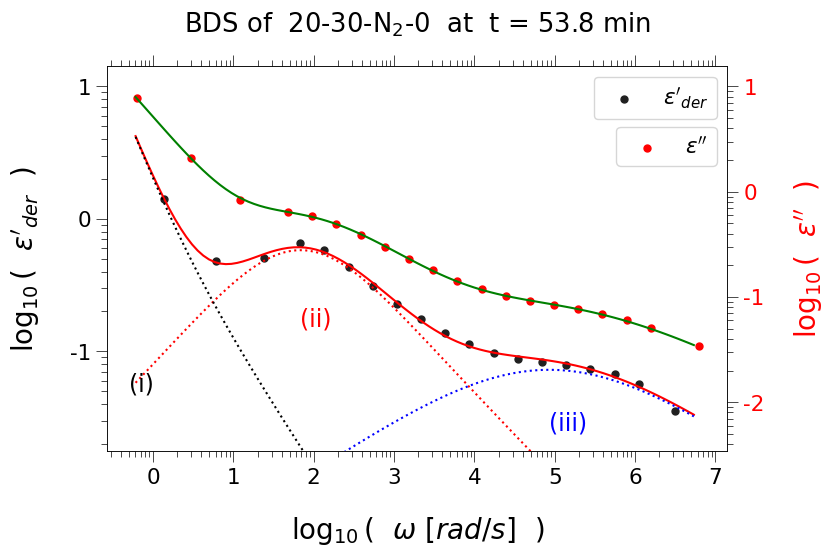

fit score 774676539.0
fit parameters [1.864, 0.6187, 68.95, 0.4033, 0.4103, 86860.0, 66.54, 0.9201, 0.06329]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


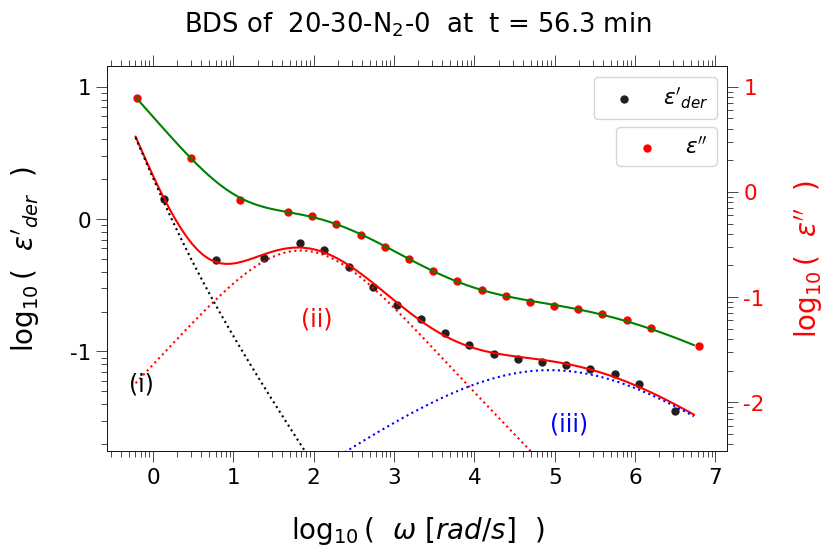

fit score 29898.0
fit parameters [0.07698, 0.8628, 2000.0, 0.1397, 0.5134, 106900.0, 4978.0, 0.5434, 1.933e-07]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


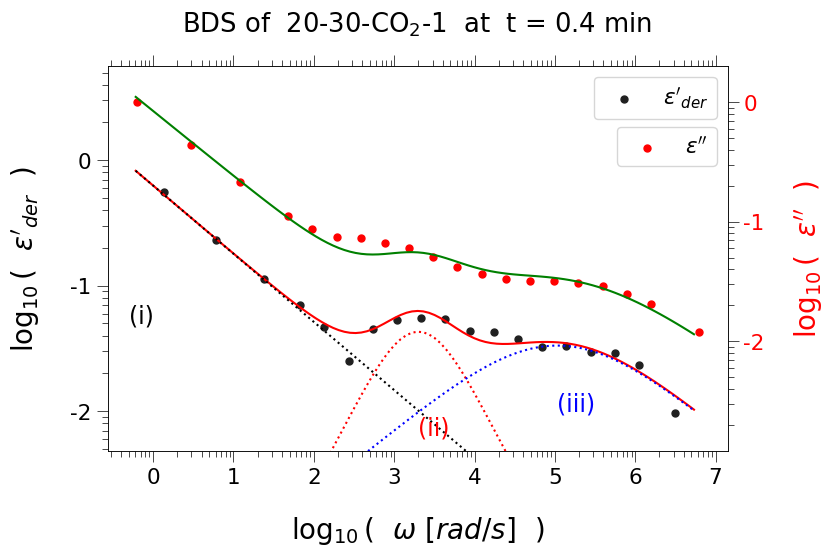

fit score 5027259.0
fit parameters [0.2876, 0.3133, 258.0, 0.04574, 0.7412, 282200.0, 7.608, 0.6792, 0.03798]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


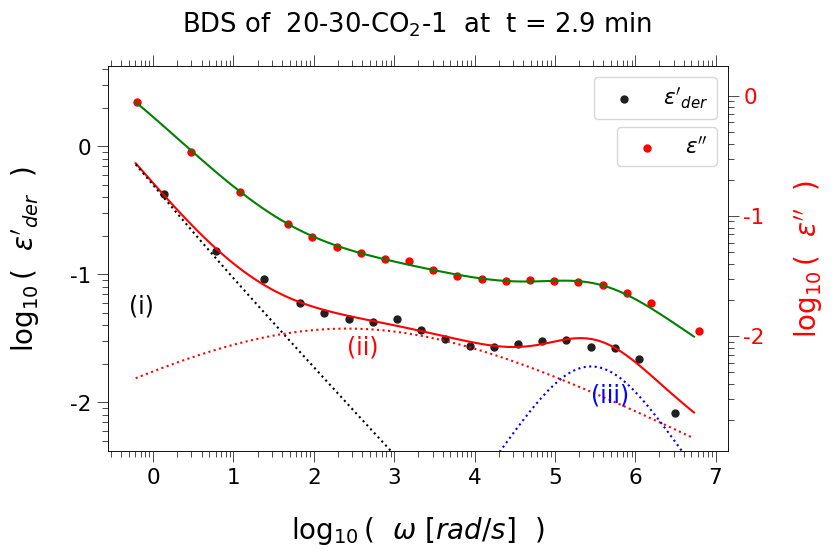

fit score 4504360.0
fit parameters [0.2476, 0.3083, 330.1, 0.03913, 0.7477, 296800.0, 200.4, 0.6634, 0.0001848]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


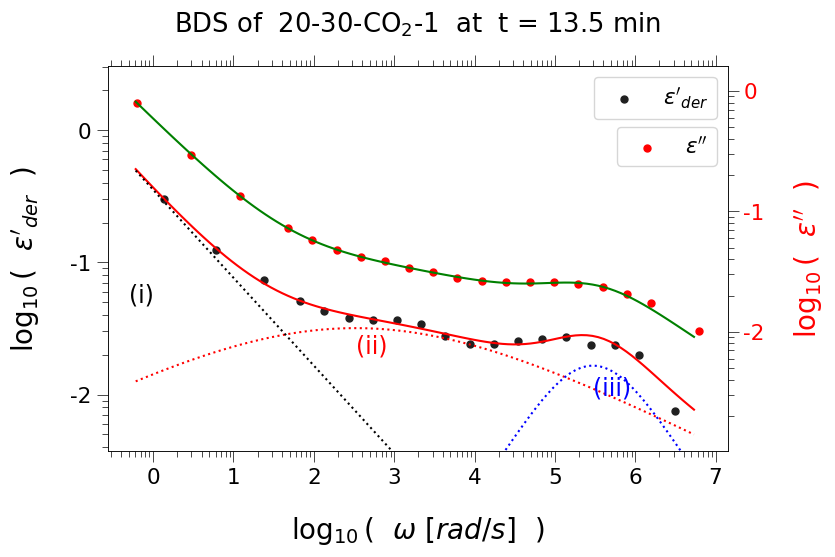

fit score 3510810.0
fit parameters [0.2583, 0.2852, 349.2, 0.02601, 0.8202, 369400.0, 6129.0, 0.7133, 2.969e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


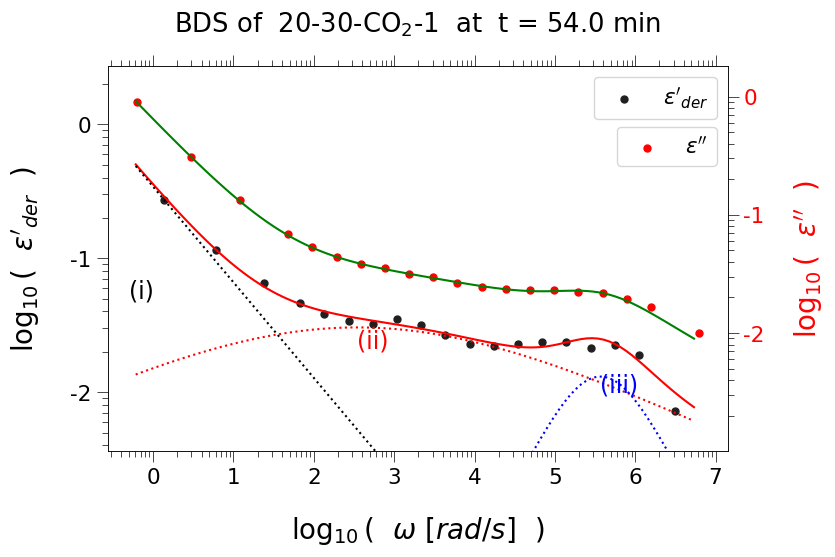

fit score 1759815.0
fit parameters [0.2812, 0.2696, 225.8, 0.02022, 0.8739, 420100.0, 10130.0, 0.7696, 4.505e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


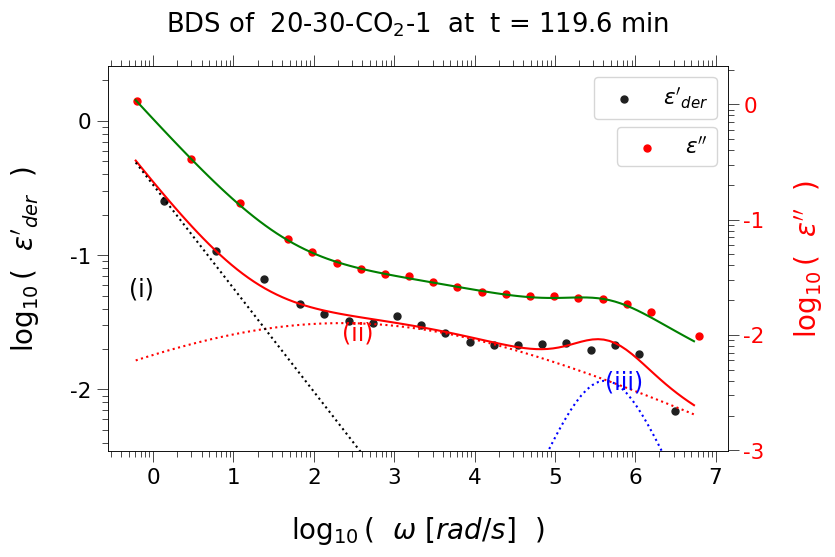

fit score 62898.0
fit parameters [0.4381, 0.7383, 7.336, 0.2668, 0.2773, 3956.0, 49990.0, 1.0, 1.388e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


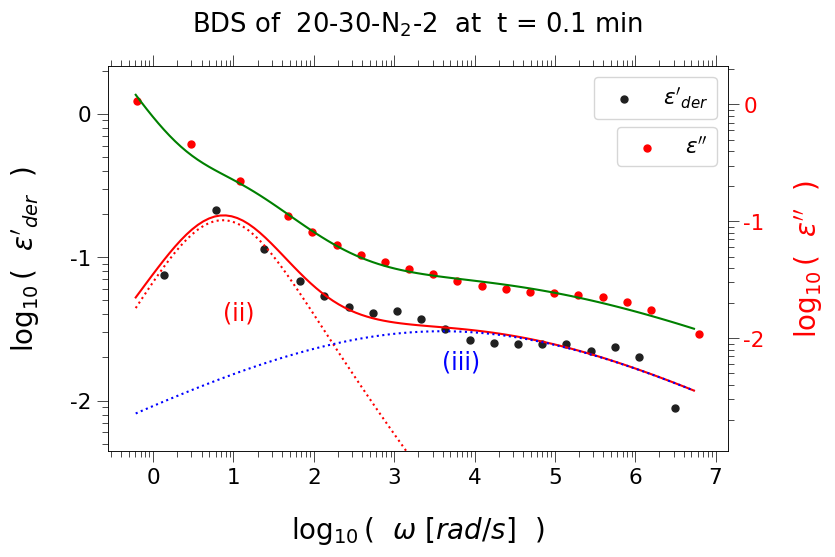

fit score 1008753.0
fit parameters [1.953, 0.6246, 1.721, 0.2676, 0.2794, 9574.0, 15900.0, 1.0, 2.574e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


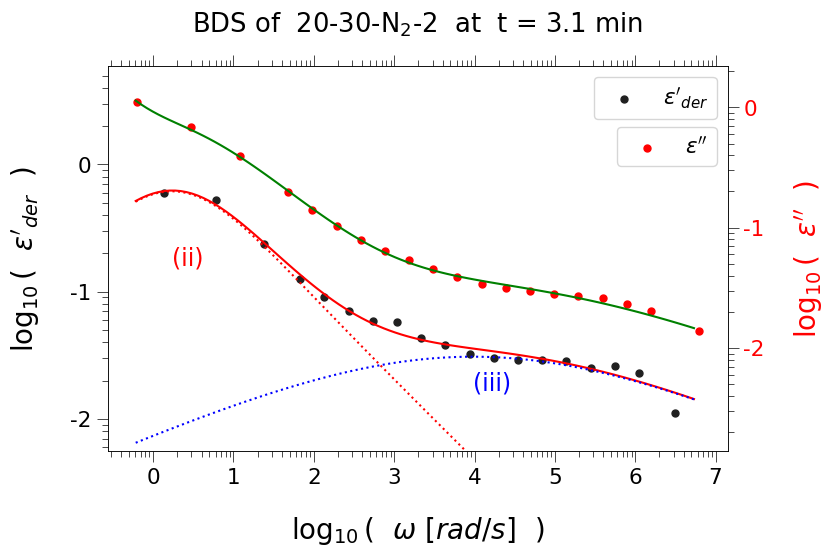

fit score 2280569.0
fit parameters [1.953, 0.6395, 3.069, 0.25, 0.2971, 17420.0, 13260.0, 1.0, 2.291e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


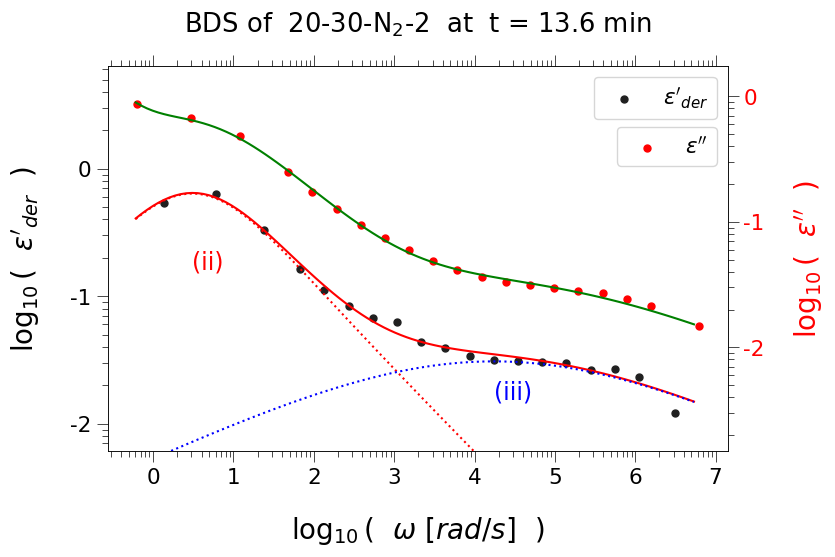

fit score 10081569.0
fit parameters [1.792, 0.6674, 7.222, 0.3121, 0.263, 11990.0, 19580.0, 1.0, 1.934e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


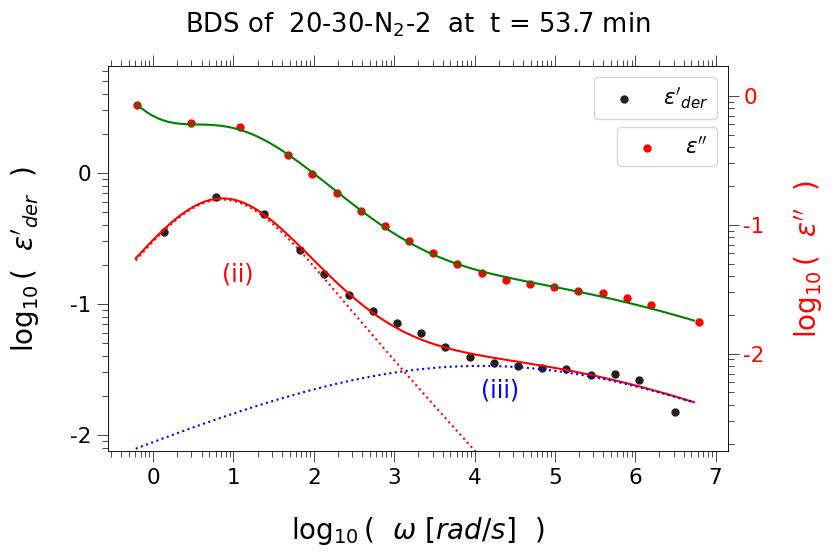

fit score 17714549.0
fit parameters [1.719, 0.6932, 13.44, 0.3808, 0.243, 7000.0, 77150.0, 1.0, 7.433e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


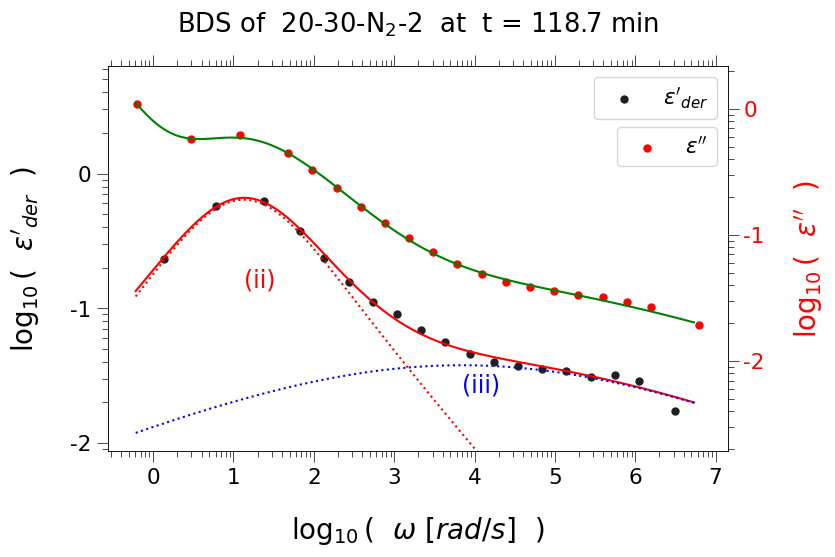

fit score 579397.0
fit parameters [0.09884, 0.5661, 1087.0, 0.07518, 0.5701, 227100.0, 22920.0, 0.605, 7.148e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


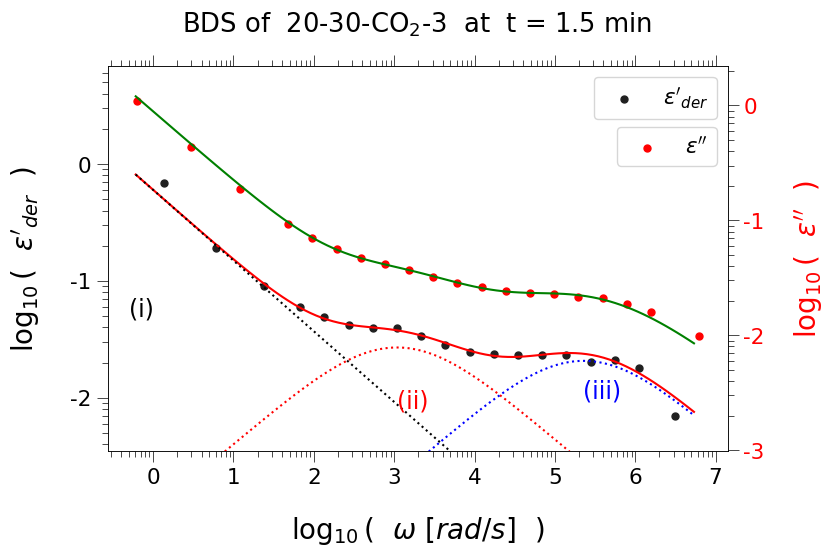

fit score 1939419.0
fit parameters [0.219, 0.3137, 953.3, 0.02, 0.8736, 435800.0, 34760.0, 0.6475, 8.533e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


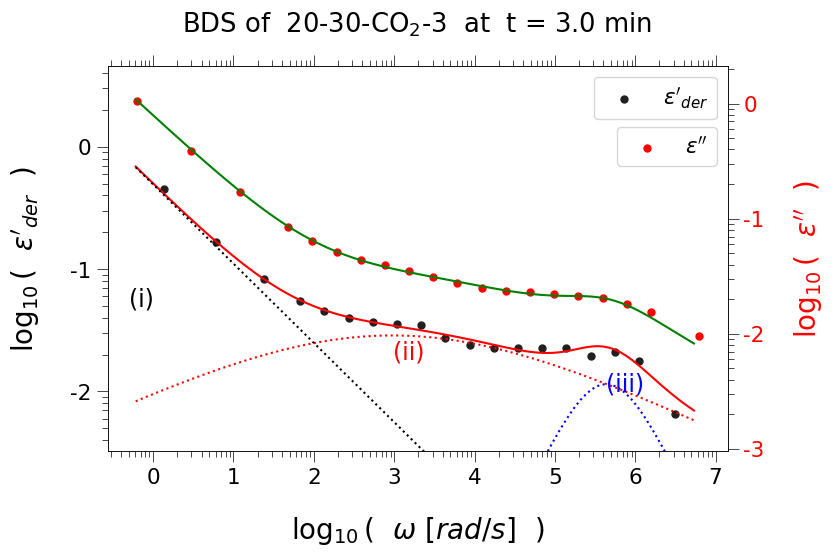

fit score 2083665.0
fit parameters [0.2425, 0.2981, 458.2, 0.02061, 0.8646, 419600.0, 44430.0, 0.6959, 1.496e-07]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


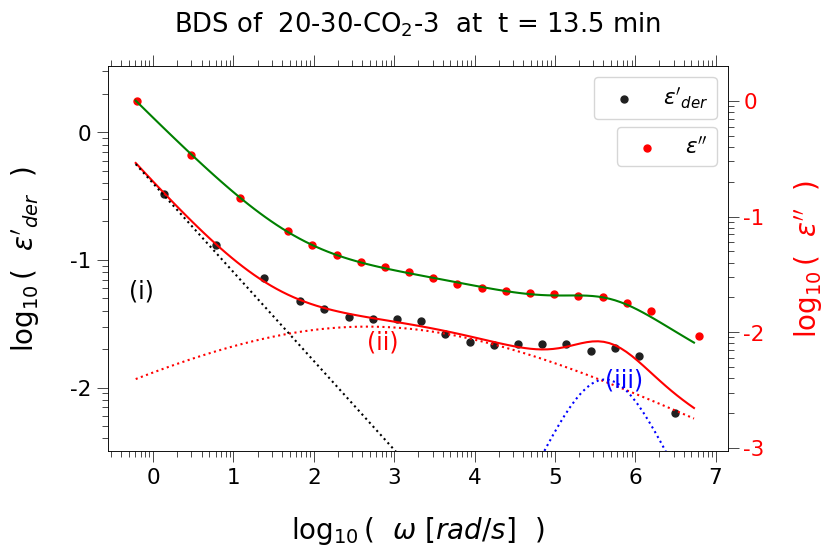

fit score 1143275.0
fit parameters [0.275, 0.2777, 247.7, 0.01907, 0.8895, 448800.0, 10550.0, 0.7607, 4.153e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


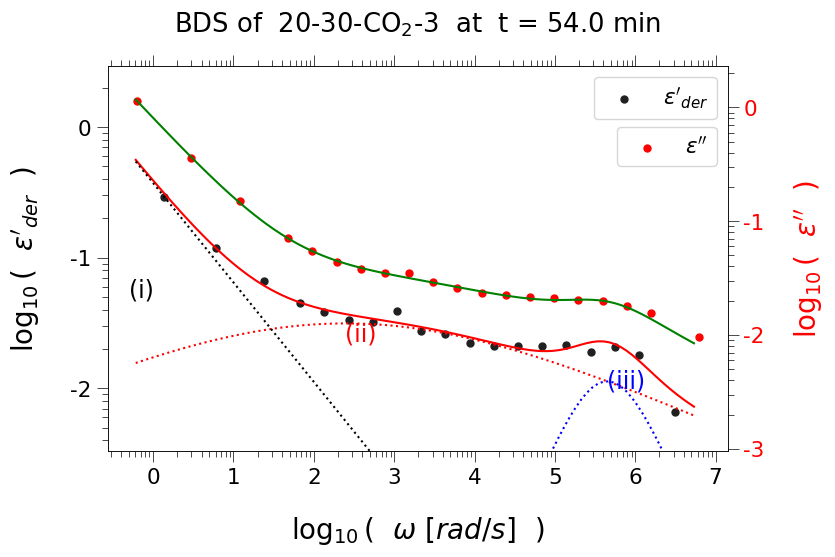

fit score 2794020.0
fit parameters [0.292, 0.2635, 179.1, 0.01754, 0.901, 459700.0, 14940.0, 0.7877, 4.205e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


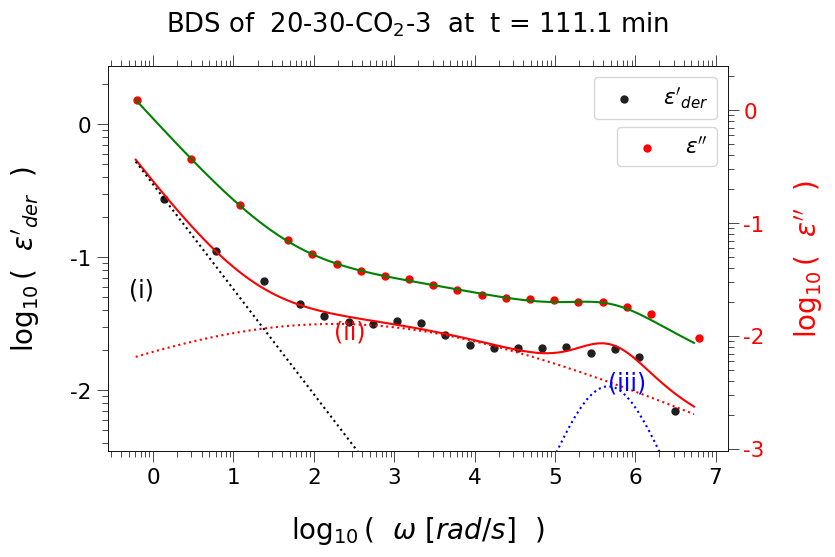

fit score 392305.0
fit parameters [2.853, 0.4242, 0.196, 0.1197, 0.4273, 125500.0, 26530.0, 1.0, 2.157e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


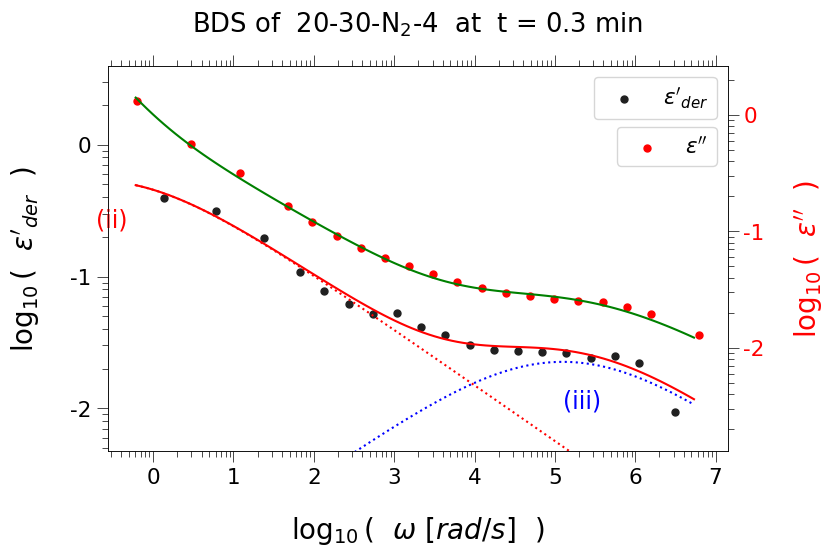

fit score 1280598.0
fit parameters [1.895, 0.6086, 3.393, 0.2518, 0.2916, 17600.0, 26700.0, 1.0, 2.209e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


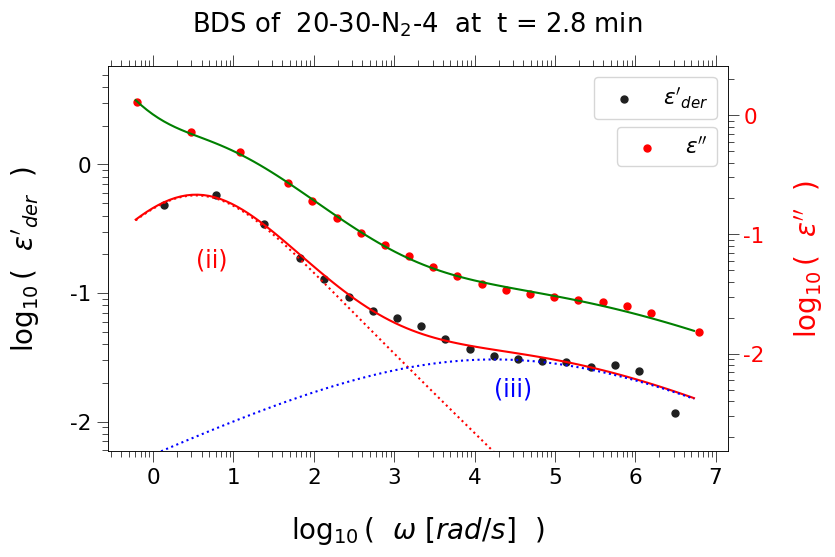

fit score 3548033.0
fit parameters [1.878, 0.6379, 7.498, 0.2726, 0.289, 23130.0, 51230.0, 1.0, 1.289e-05]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


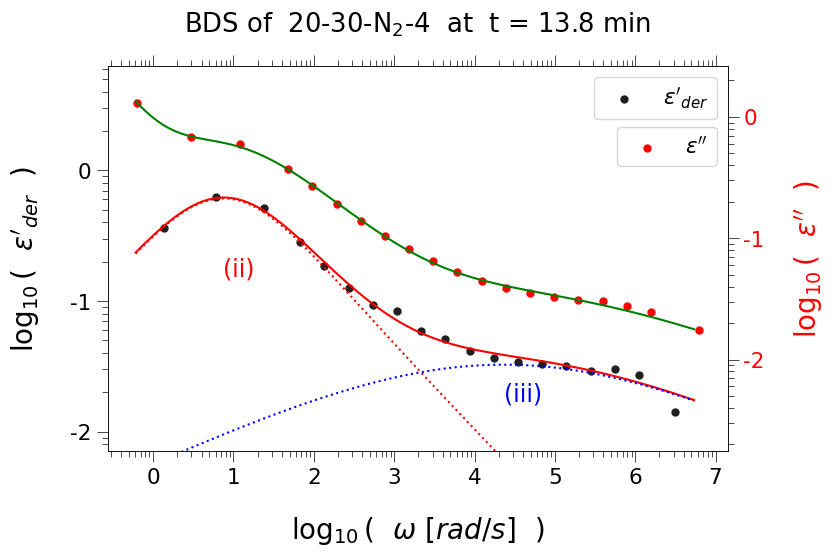

fit score 6456534.0
fit parameters [1.805, 0.6621, 11.27, 0.304, 0.2755, 18460.0, 243300.0, 1.0, 2.701e-06]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


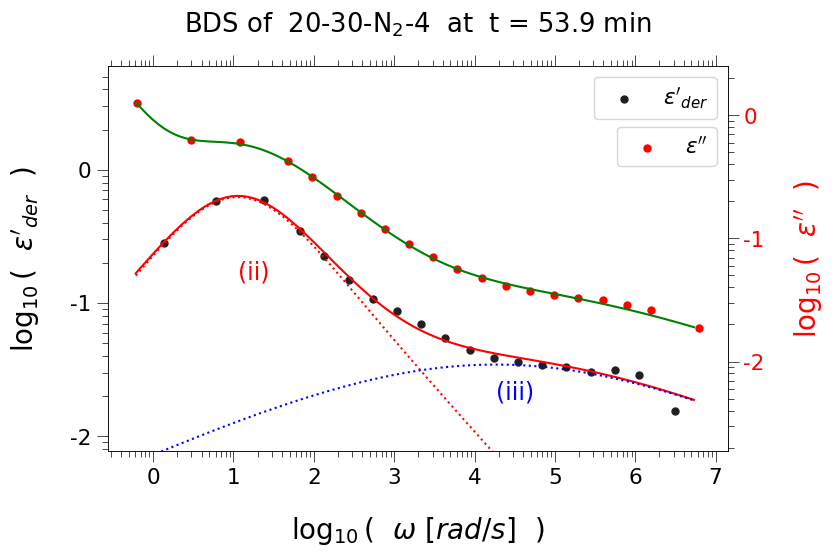

fit score 11039919.0
fit parameters [1.779, 0.676, 14.39, 0.342, 0.2601, 12660.0, 22080000.0, 1.0, 3.434e-08]


/tmp/ipykernel_40280/3649991613.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_xticks()])
/tmp/ipykernel_40280/3649991613.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax1.get_yticks()])
/tmp/ipykernel_40280/3649991613.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax2.get_yticks()])


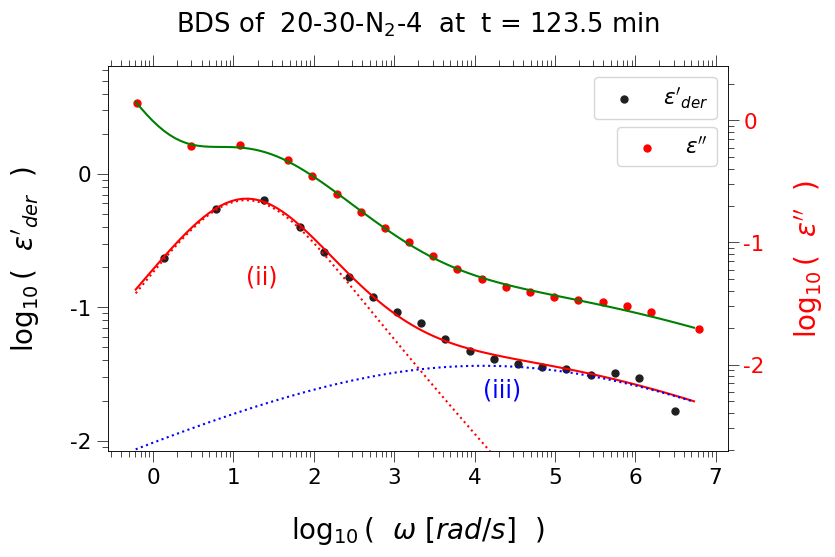

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

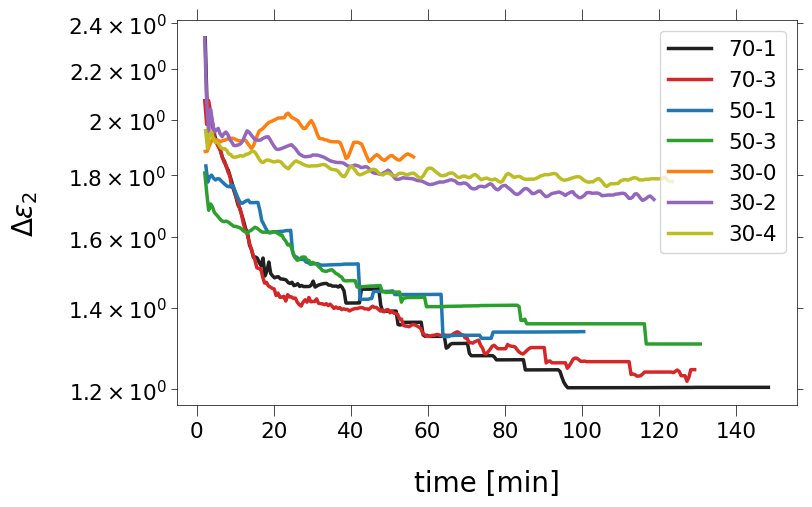

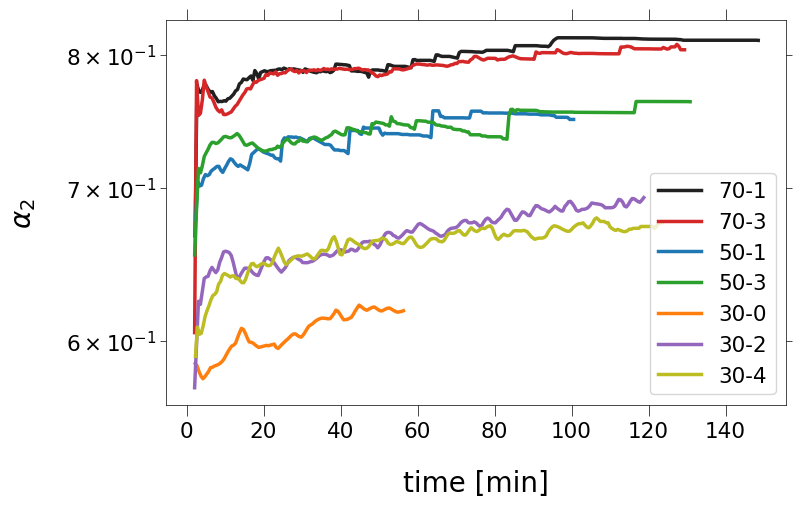

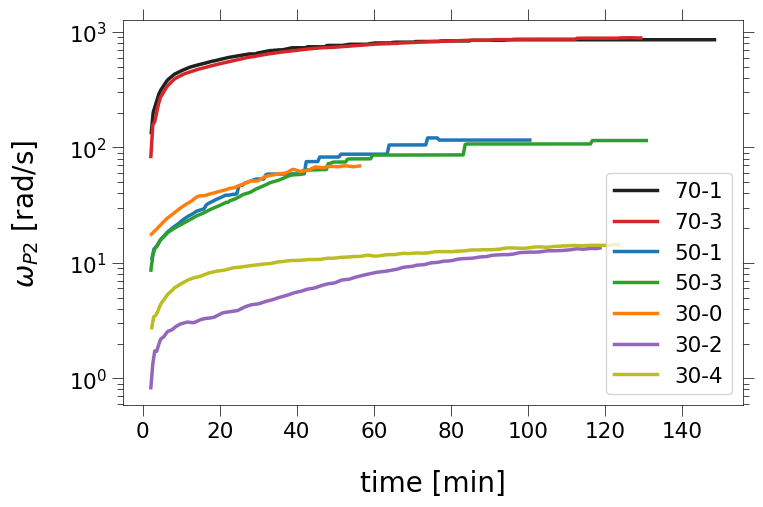

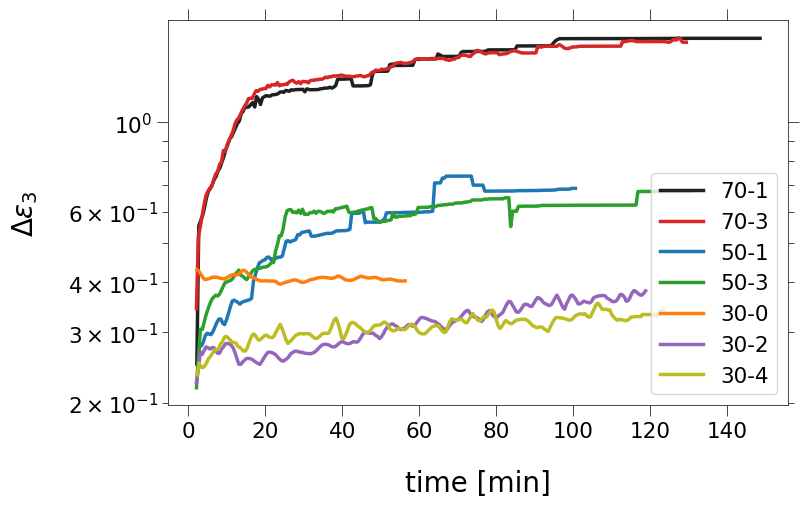

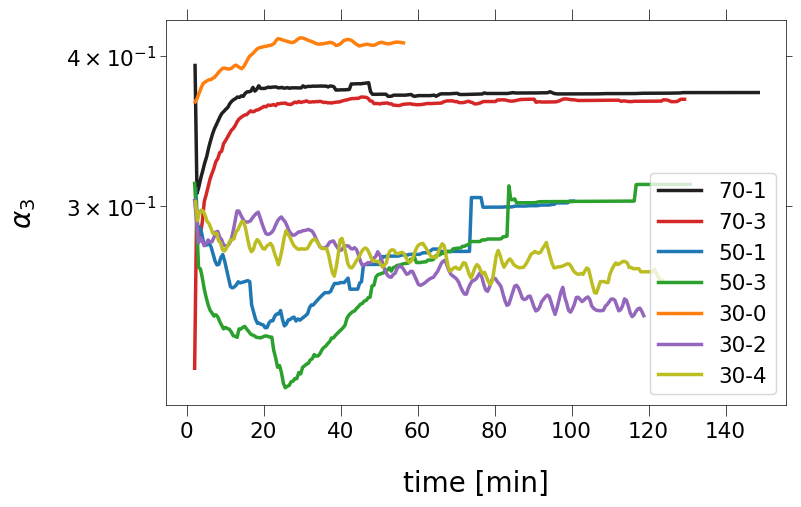

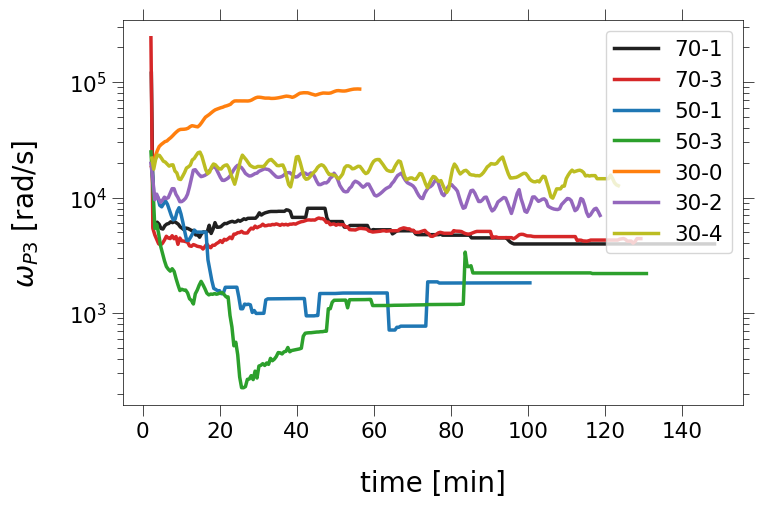

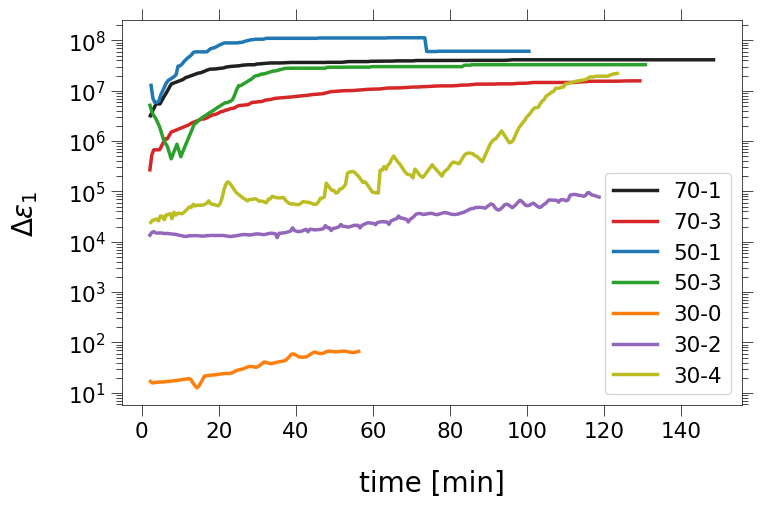

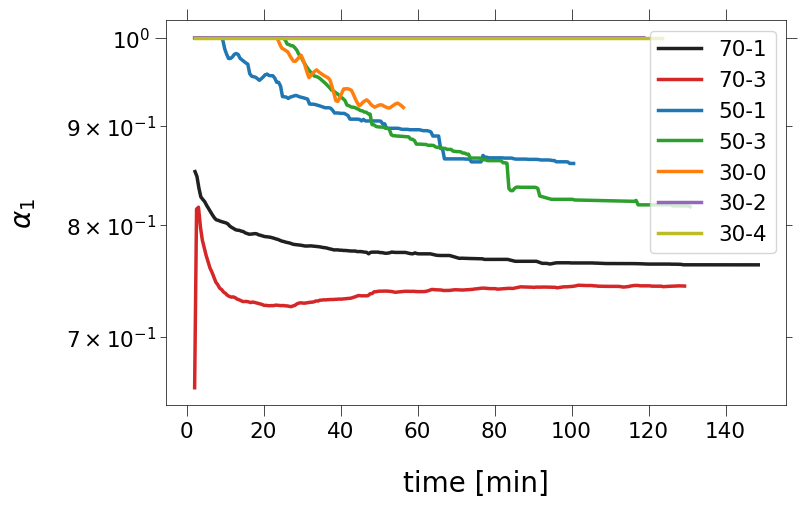

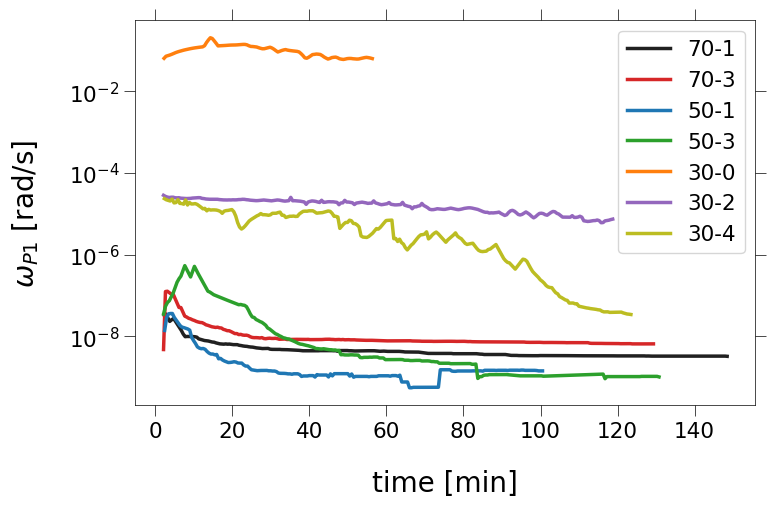

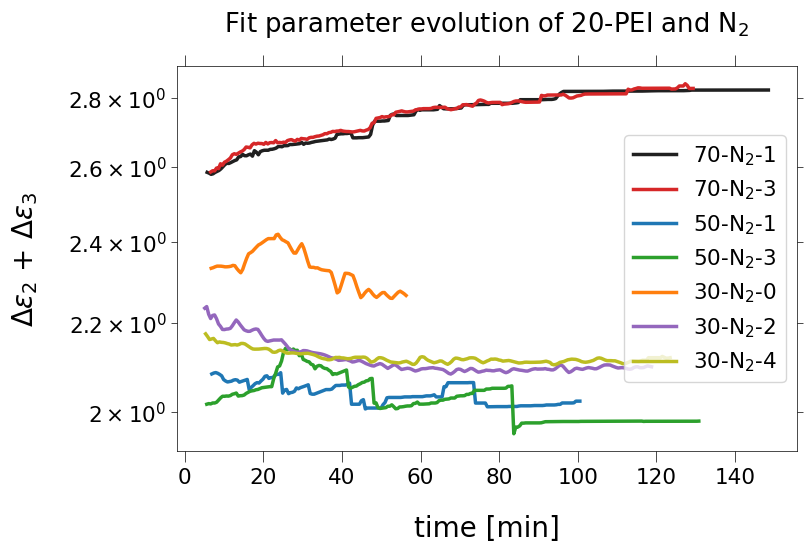

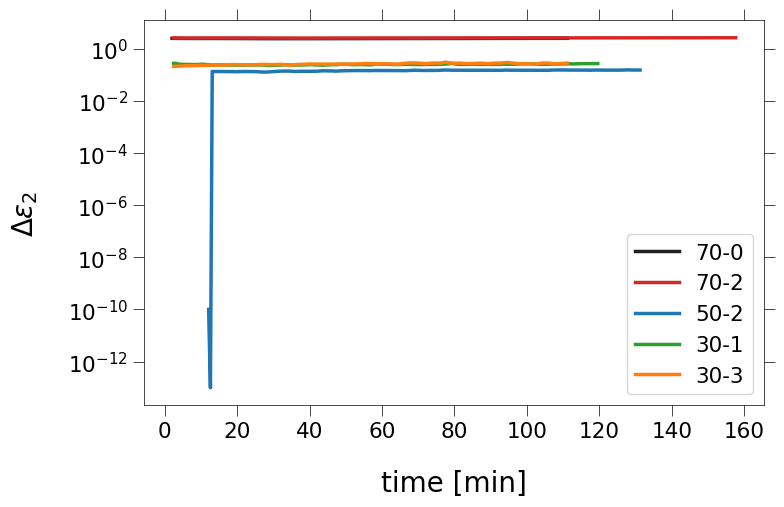

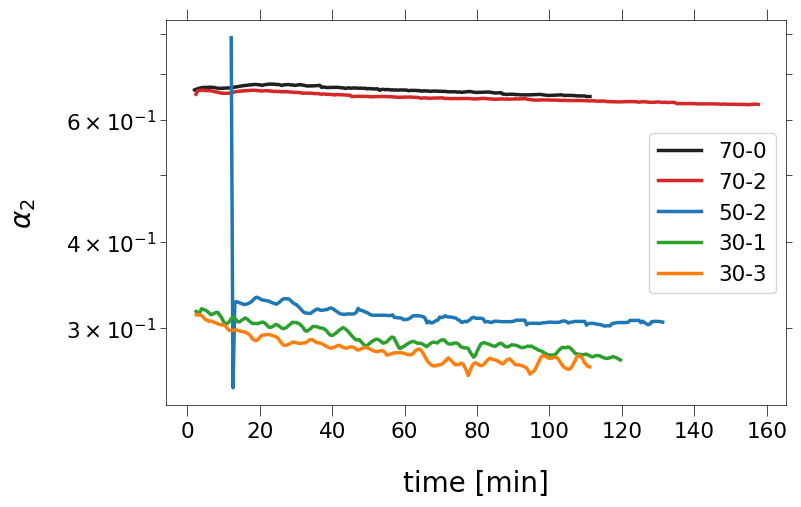

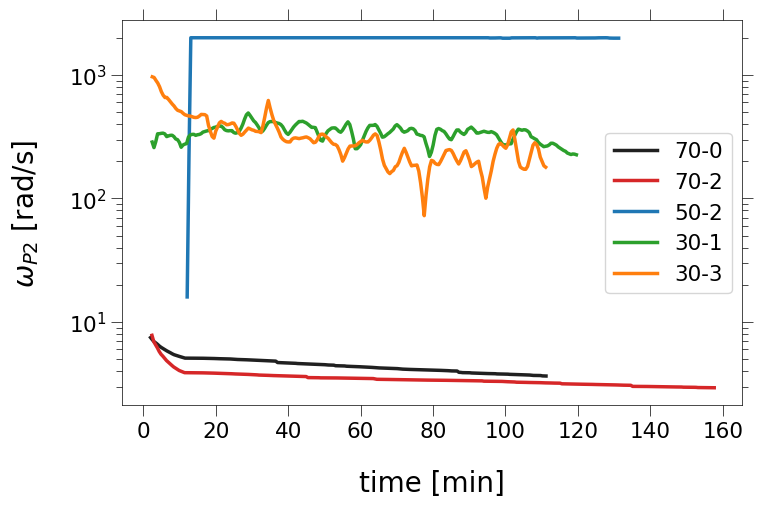

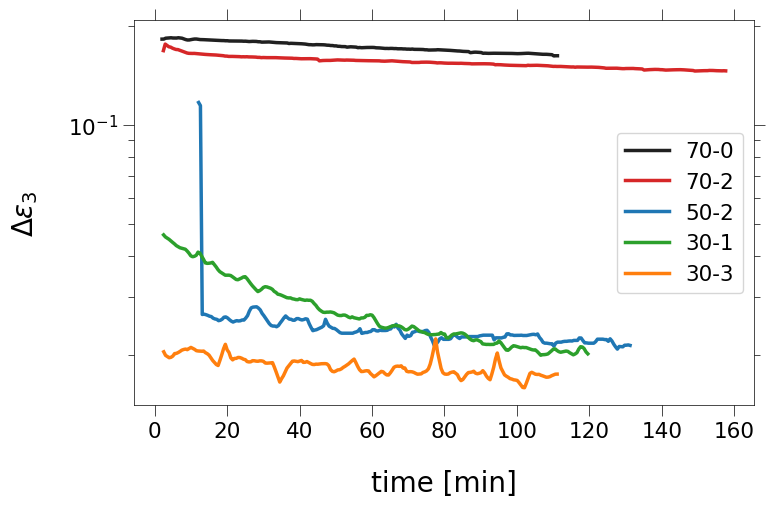

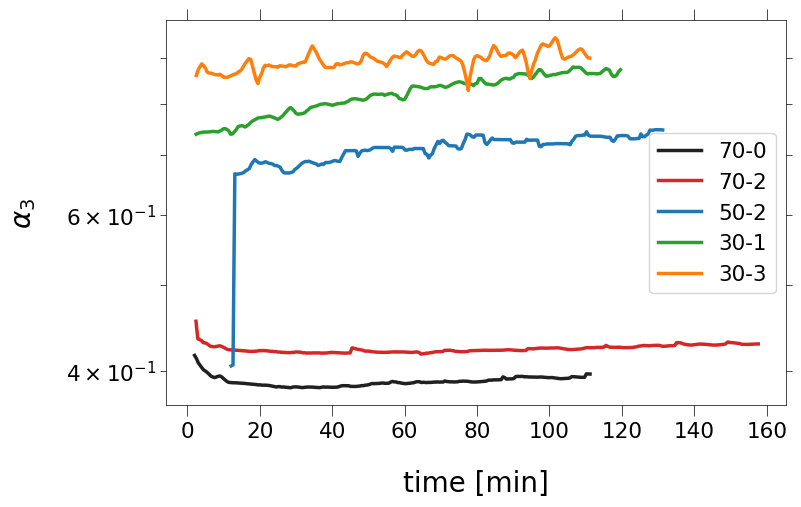

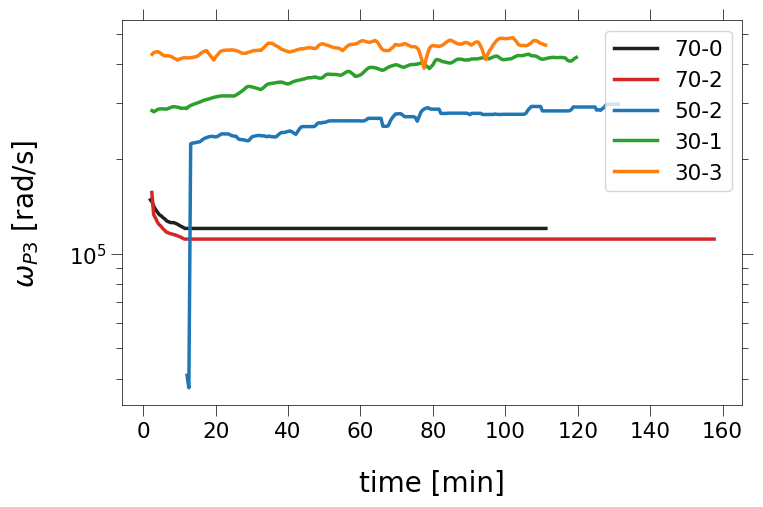

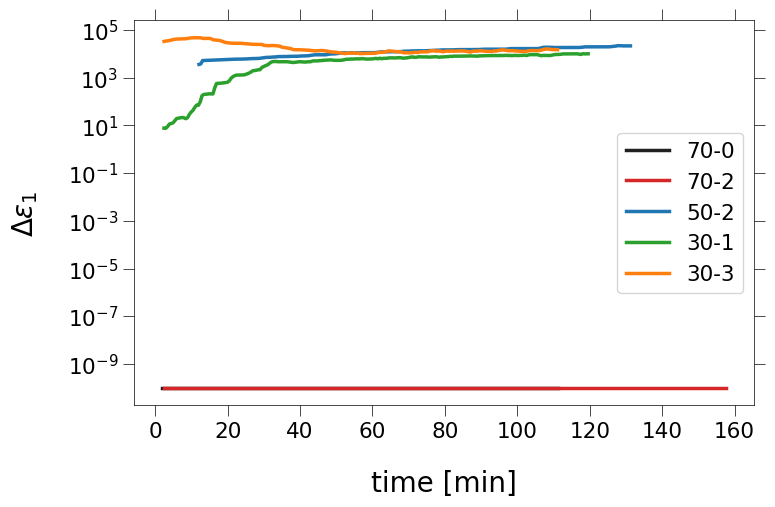

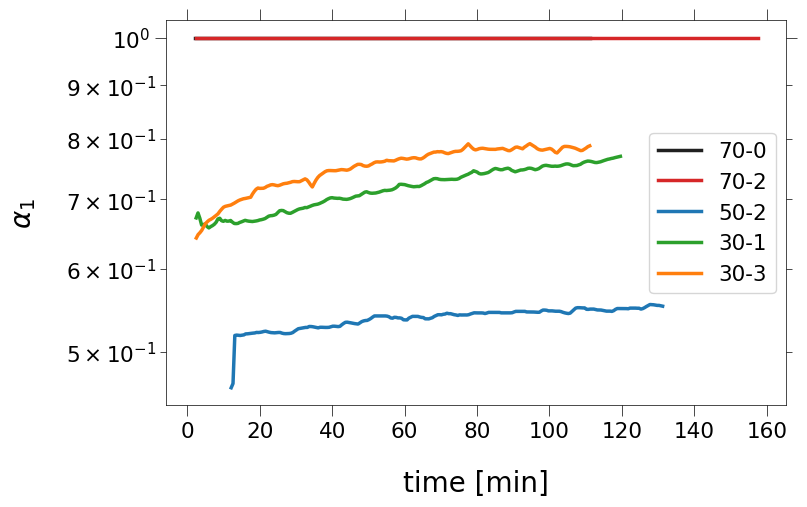

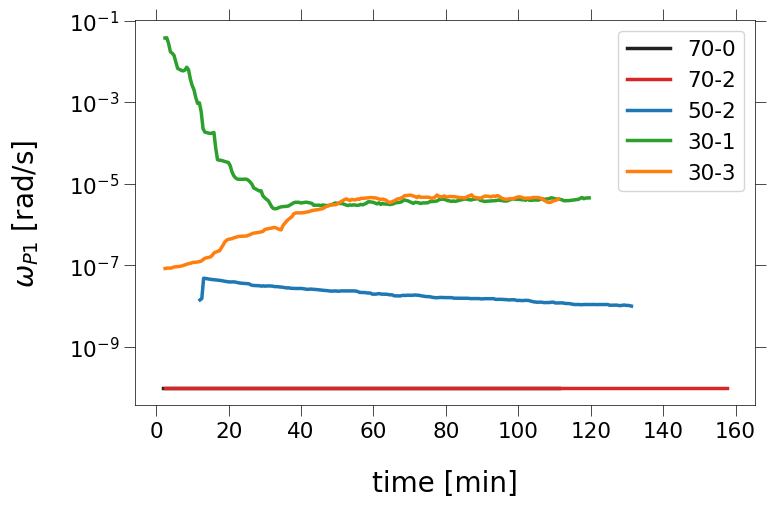

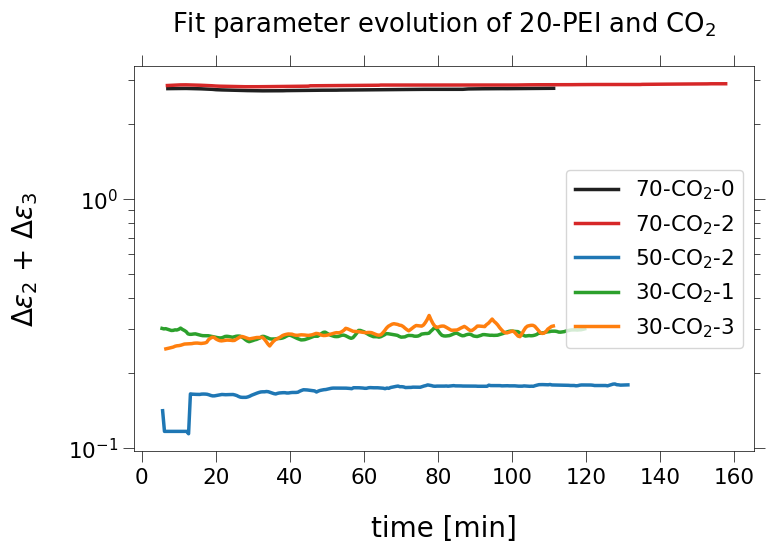

In [ ]:
### Plot time evolution of fit parameters

title_text = "Fit parameter evolution of "+ SAMPLE + " and "

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

# j: run with specific temp and gas
# i: parameters

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, lw=2.5)
            #plt.title(title_text + gas)

        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig(results_folder + "/param/"+gas+" "+p_file_labels[i]+".pdf", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, lw=2.5)
        plt.title(title_text + gas)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

[0.89535, 5.1172, 1.1244, 64.772, 0.52661]
[1.1037, 6.1078, 1.0173, 156.14, 0.47761]


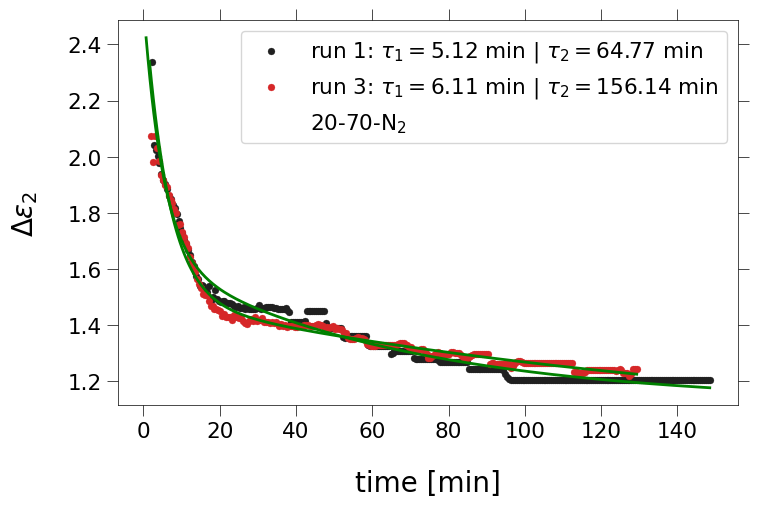

[0.60603, 35.812, 1.2827]
[0.4493, 51.919, 1.2802]


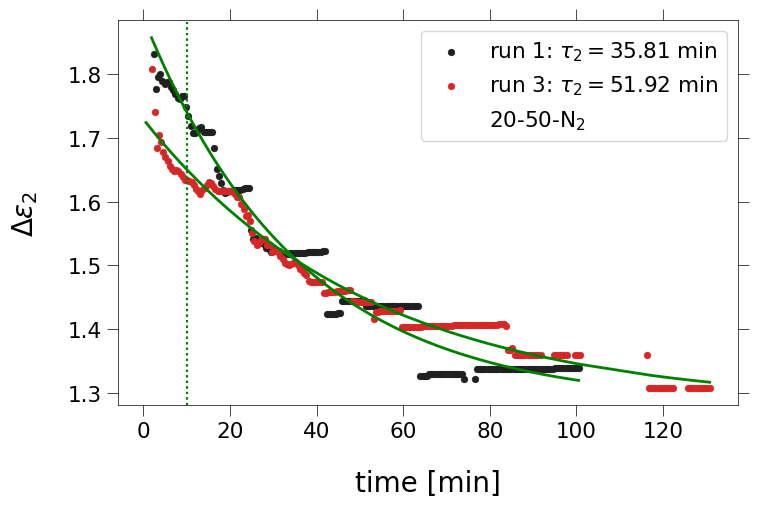

[0.31631, 45.812, 1.6998]
[0.12868, 31.314, 1.7818]


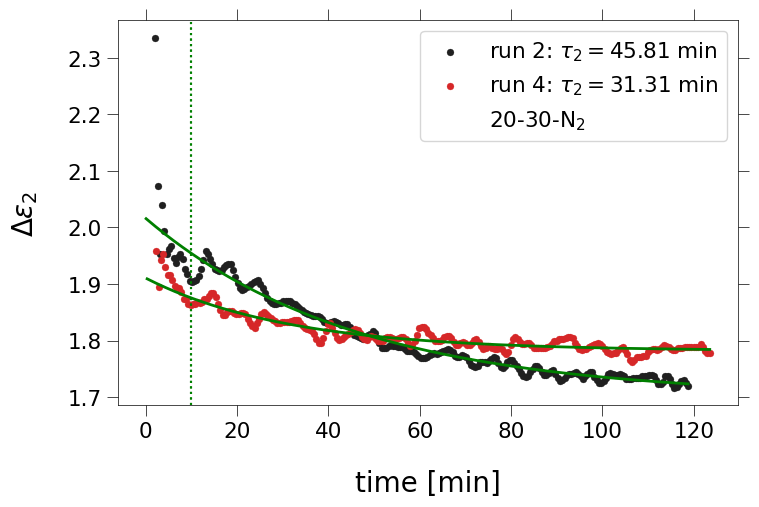

[-0.057427, 84.363, 0.82595]
[-0.047151, 49.11, 0.80756]


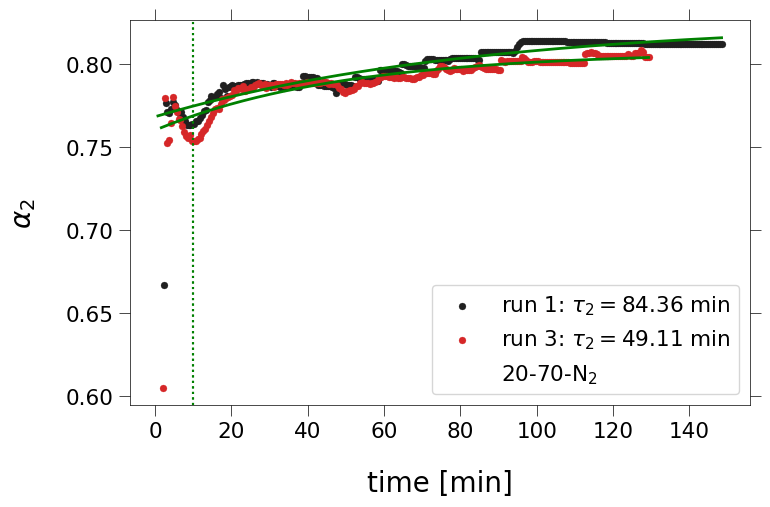

[-0.060057, 60.65, 0.76722]
[-184.47, 667370.0, 185.2]


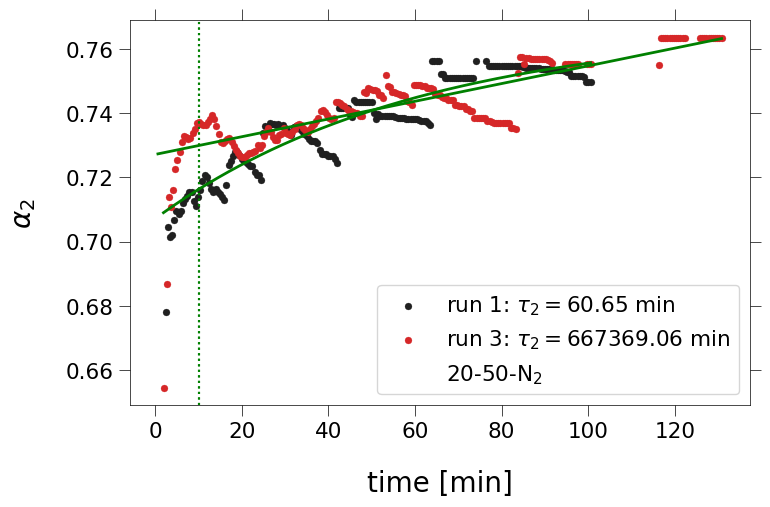

[-0.13024, 202.5, 0.76547]
[-0.046855, 38.441, 0.67527]


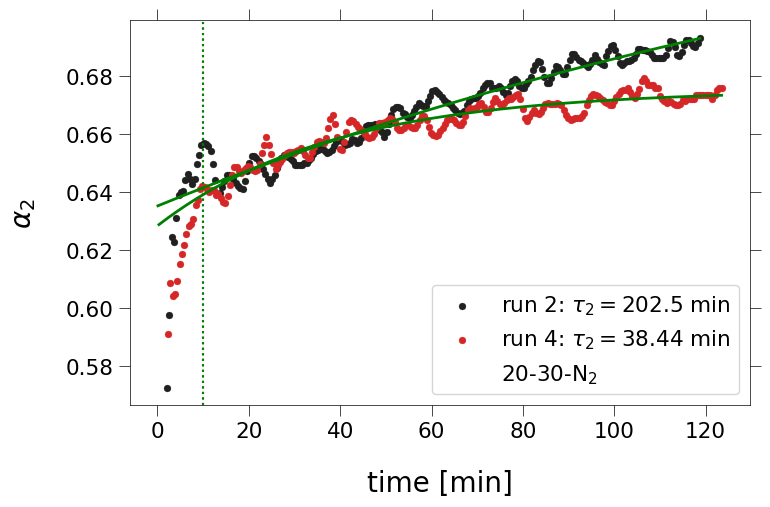

[-424.31, 2.6434, 865.62, 28.732, -570.15]
[-580.54, 2.2367, 907.08, 37.25, -635.97]


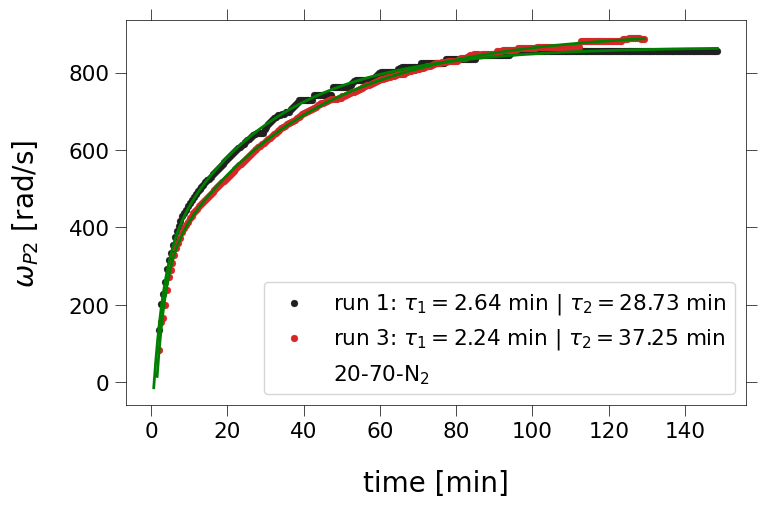

[-170.8, 48.709, 143.34]
[-146.07, 56.583, 131.02]


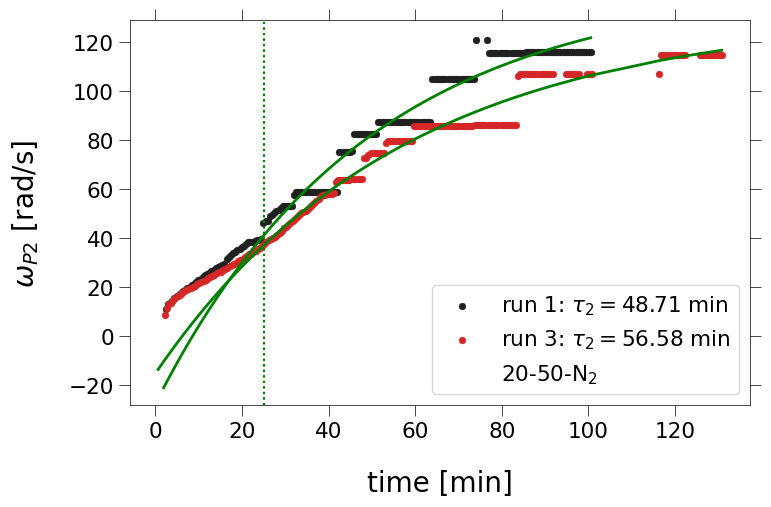

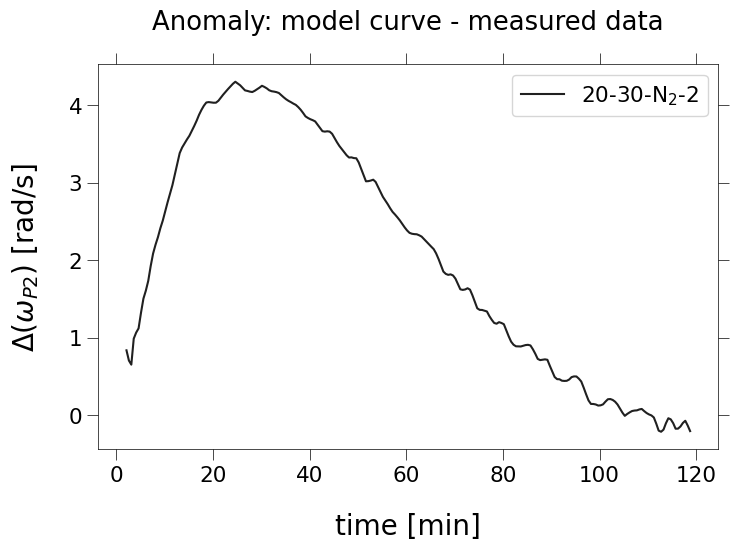

[-6.7096, 7.6255, 19.942, 153.65, -12.348]


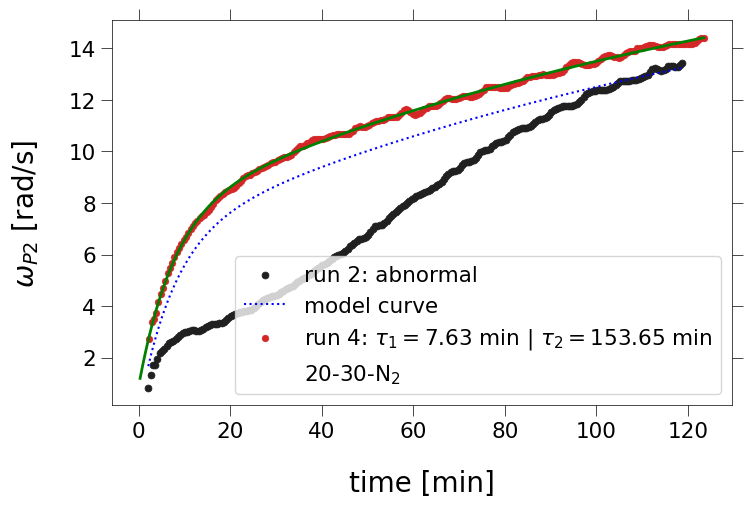

[-0.91179, 4.3959, 1.7222, 57.703, -0.85634]
[-0.9728, 7.5961, 1.8891, 128.94, -0.7567]


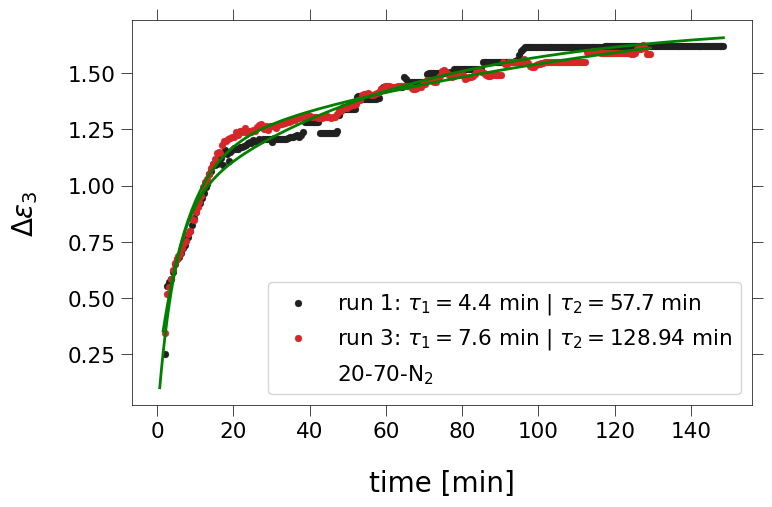

[-0.52795, 34.748, 0.72978]
[-0.49644, 16.776, 0.63867]


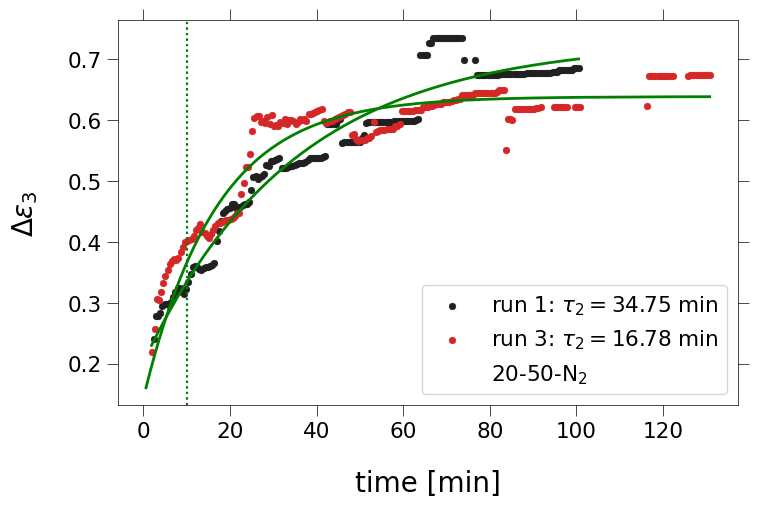

[-0.2473, 96.276, 0.44661]
[-0.08152, 100.93, 0.35712]


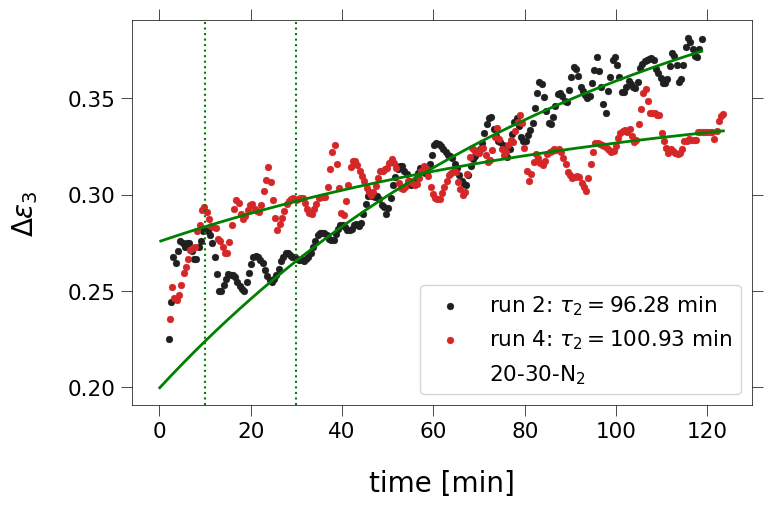

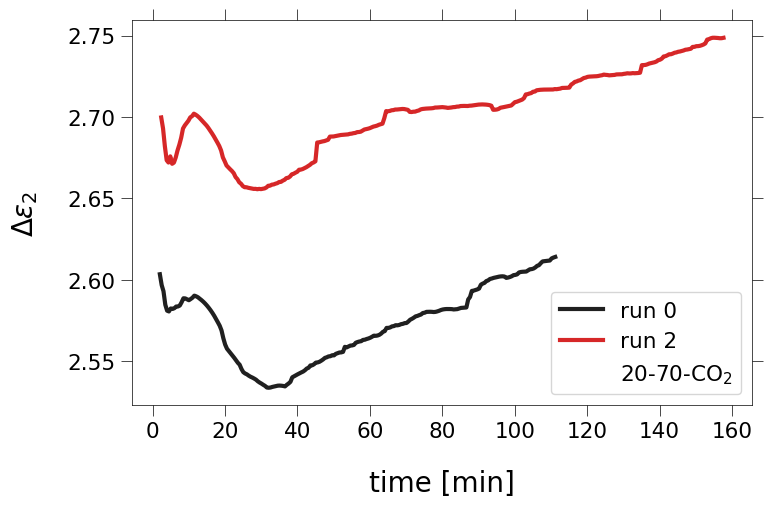

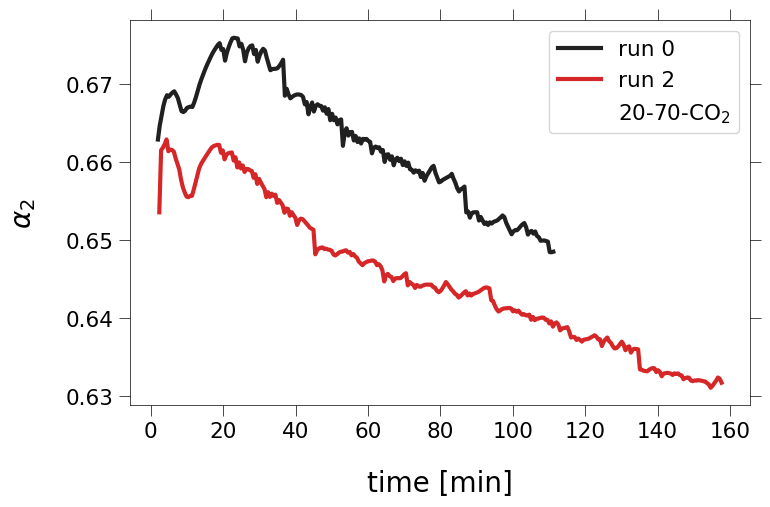

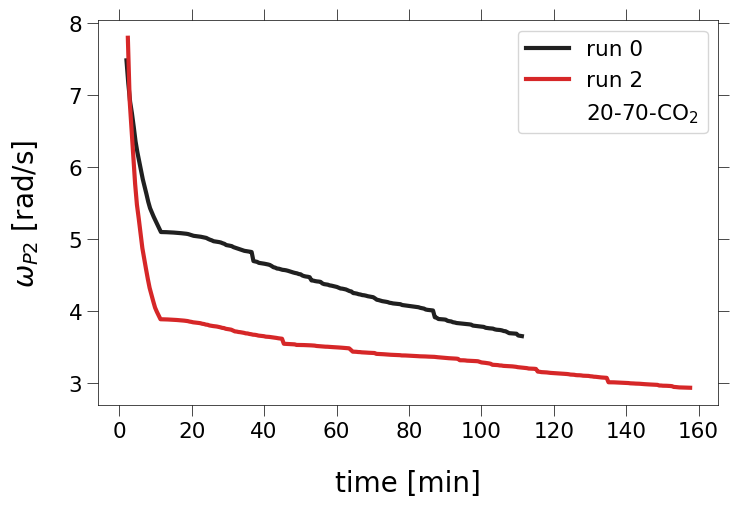

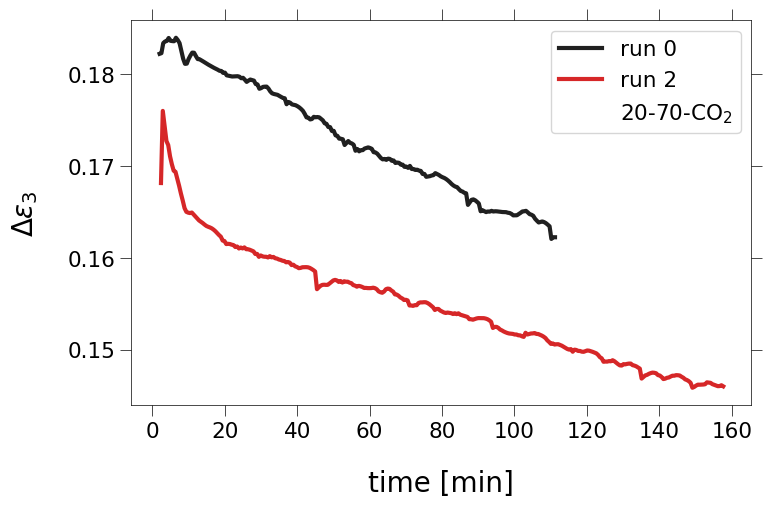

In [8]:
### parameters by temperature in N2

title_text = "Fit parameter evolution / exponential fits for " + SAMPLE_SHORT +"-"

def exp(x, a, b, c) :
    return a * np.exp(-x/b) + c
def exp2(x, a, b, c, d, e) :
    return a * np.exp(-x/b) + c + e * np.exp(-x/d)

p0_list = [
    [0.8339, 5.2189, 1.2384, 40.091, 0.44262],
    [0.88466, 7.7722, 4.3142e-11, 768.78, 1.4709],
    [0.61185, 32.341, 1.2989],
    [0.47537, 57.774, 1.2508],
    [0.31608, 45.815, 1.6999],
    [0.12895, 31.238, 1.7819],
    [-0.041573, 27.38, 0.80124],
    [-0.042833, 61.915, 0.8071],
    [-0.059169, 34.301, 0.75737],
    [-17.644, 60464.0, 18.371],
    [-0.1303, 202.91, 0.76558],
    [-0.046935, 38.333, 0.67525],
    [-327.95, 2.9828, 845.96, 25.523, -572.6],
    [-597.68, 2.3191, 907.41, 37.63, -624.68],
    [-168.88, 44.715, 138.8],
    [-149.38, 58.953, 134.69],
    [-6.7167, 7.5933, 19.897, 152.68, -12.313],
    [-0.79511, 4.4321, 1.5741, 38.544, -0.75878],
    [-0.84687, 10.533, 2.4398, 334.52, -1.265],
    [-0.50919, 33.138, 0.71171],
    [-0.42379, 23.027, 0.66063],
    [-0.24722, 96.58, 0.44685],
    [-0.081276, 99.864, 0.35672]]

p_i = 0

look_at = [0, 1, 2, 3]
idp_out = ["3022"]
idp_2exp = ["7010", "7030", "7012", "7032", "7013", "7033", "3042"]
start = [0, 0, 5, 5, 5, 5, 5, 5, 10, 10, 25, 25, 0, 0, 30, 0]
s_i = 0

for gas in GASES :
    for i in look_at :

        for temperature in TEMPS :
            if gas[0] == "C" and temperature != 70 :
                continue
            temp = str(temperature)

            plt.xscale('linear')
            plt.yscale('linear')

            for j, id in enumerate(ID) :
                if id[3] != gas[0] or id[0] != temp[0] or (id[0]=='3' and id[-1]=='0') :
                    continue
                label0 = "run " + id[-1]
                label_id = SAMPLE_SHORT + '-' + id[:-2]
                idp = temp + id[-1] + str(i)
                t, p = DT_ALL[j][:], P_ALL[j][i][:]
                cutoff = 100
                pltt = t > 2

                if gas[0] == "C" :
                    plt.plot(t[pltt], p[pltt], label=label0, lw=3)
                    continue


                if idp in idp_out :
                    label = label0 + ": abnormal"
                    y2 = exp2(t[pltt], *[-6.717, 7.593, 18.9, 152.7, -12.31])
                    plt.plot(t[pltt], y2-p[pltt], label=SAMPLE_SHORT+'-'+id)
                    plt.title("Anomaly: model curve - measured data")
                    plt.xlabel("time [min]")
                    plt.ylabel("$\\Delta\\left(\\omega_{P2}\\right)$ [rad/s]")
                    plt.legend()
                    #plt.savefig(results_folder + "/param2/anomaly.pdf", bbox_inches='tight')
                    plt.show()
                    plt.scatter(t[pltt], p[pltt], label=label, lw=0.5)
                    plt.plot(t[pltt], y2, ls=':', color='b', label='model curve')
                    continue

                if idp not in idp_2exp :
                    fitf = exp
                    s = max(10, start[s_i])
                    fitt2 = (t > s)# & (t < cutoff)
                    try :
                        popt2, _ = curve_fit(fitf, t[fitt2], p[fitt2], p0=p0_list[p_i], bounds=((-i_, 0., 0.), (i_, i_, i_)))
                        print([round_sig(pi, 5) for pi in popt2])
                        label = label0 + f': $\\tau_2 = ${np.round(popt2[1],2)} min'

                        y2 = fitf(t, *popt2)
                        plt.plot(t, y2, color='g', lw=2)
                    except Exception as err :
                        print(str(type(err))[8:-2], ": ", err)

                    plt.axvline(s, linestyle=':', color='g')
                    s_i += 1
                    #plt.axvline(cutoff, linestyle=':', color='g')

                else :
                    fitf = exp2
                    fitt = t < cutoff
                    try :
                        popt, _ = curve_fit(fitf, t, p, p0=p0_list[p_i], bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                        print([round_sig(pi, 5) for pi in popt])
                        tau1 = np.round(min(popt[1], popt[3]),2)
                        tau2 = np.round(max(popt[1], popt[3]),2)
                        label = label0 + f': $\\tau_1 = ${tau1} min | $\\tau_2 = ${tau2} min'

                        y = fitf(t, *popt)
                        plt.plot(t, y, color='g', lw=2)
                    except Exception as err :
                        print(str(type(err))[8:-2], ": ", err)

                    #plt.axvline(cutoff, linestyle=':', color='g')

                plt.scatter(t[pltt], p[pltt], label=label, lw=0.2)
                p_i += 1
            
            plt.plot([],[],color='white',label=label_id)
            plt.xlabel("time [min]")
            plt.ylabel(p_labels[i])
            plt.legend()
            #plt.savefig(results_folder + "/param2/"+label_id+"-"+p_file_labels[i]+".pdf", bbox_inches='tight')
            plt.show()

[-3.3728, 0.861, 5.5448, 27.765, -1.6805]
[-11.642, 0.74596, 5.5949, 28.703, -1.716]


/tmp/ipykernel_40280/755915411.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


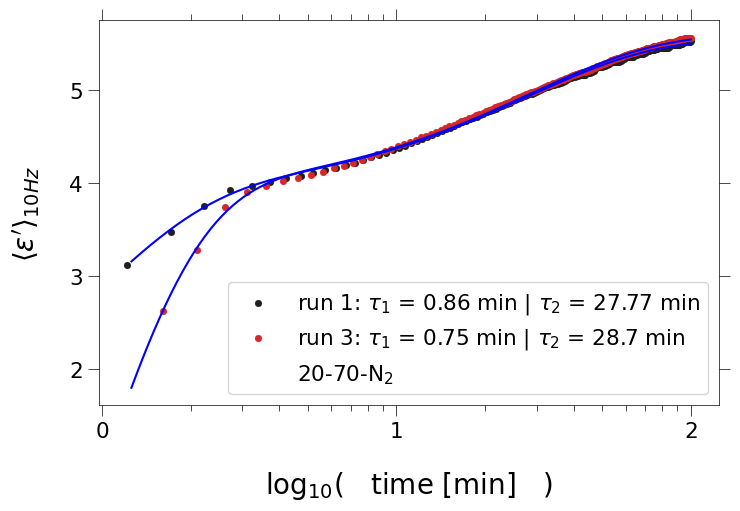

[-0.94136, 2.7641, 2.9277, 32.179, -0.75787]
[-1.2237, 1.7395, 2.8717, 27.607, -0.8998]


/tmp/ipykernel_40280/755915411.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


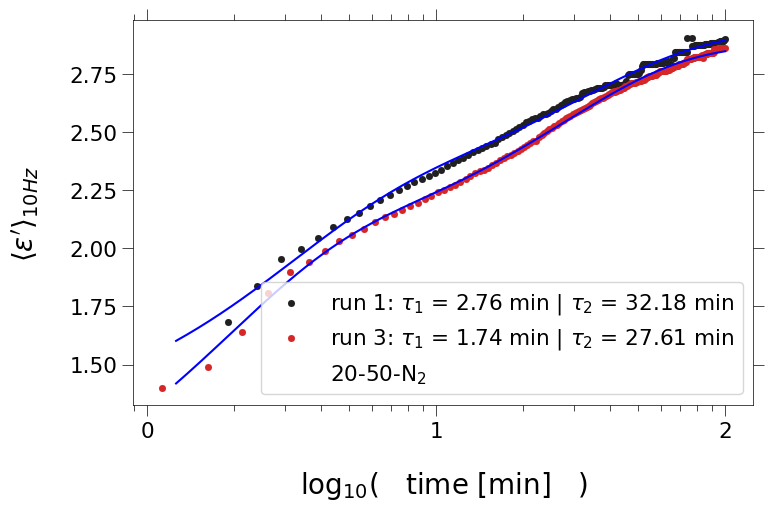

[-0.75991, 4.9523, 2.1315, 69.877, -0.4908]


/tmp/ipykernel_40280/755915411.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


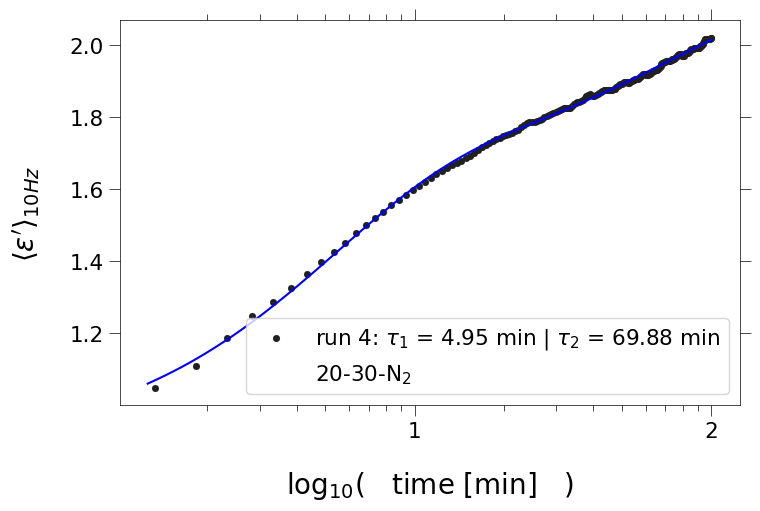

[0.54944, 3.8086, 1.3506, 97.166, 0.39684]
[1.2712, 3.2663, 1.4237, 61.509, 0.12305]


/tmp/ipykernel_40280/755915411.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


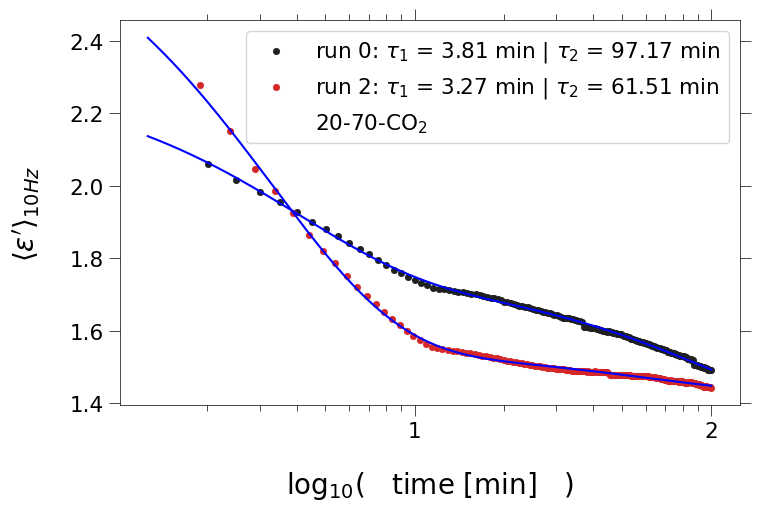

[0.36809, 1.0193, 0.48331, 5.6417, 0.28898]


/tmp/ipykernel_40280/755915411.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


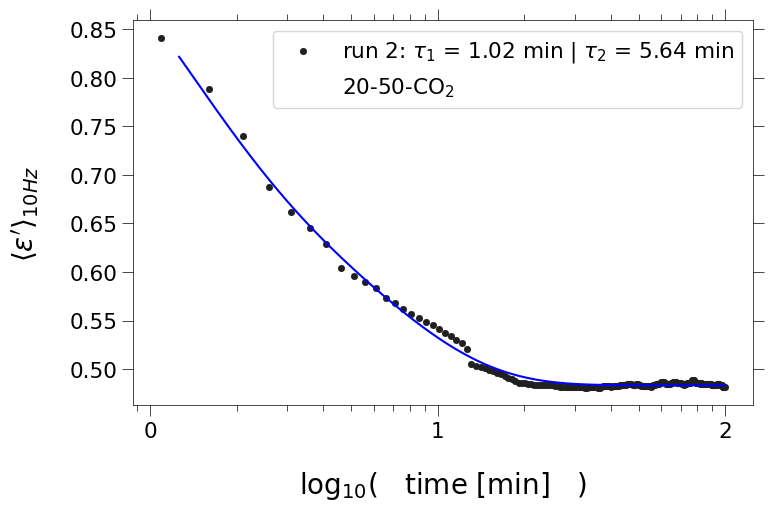

[0.13294, 5.4554, 0.40669, 53.688, 0.061411]
[0.097298, 3.6534, 0.41057, 37.532, 0.031412]


/tmp/ipykernel_40280/755915411.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])


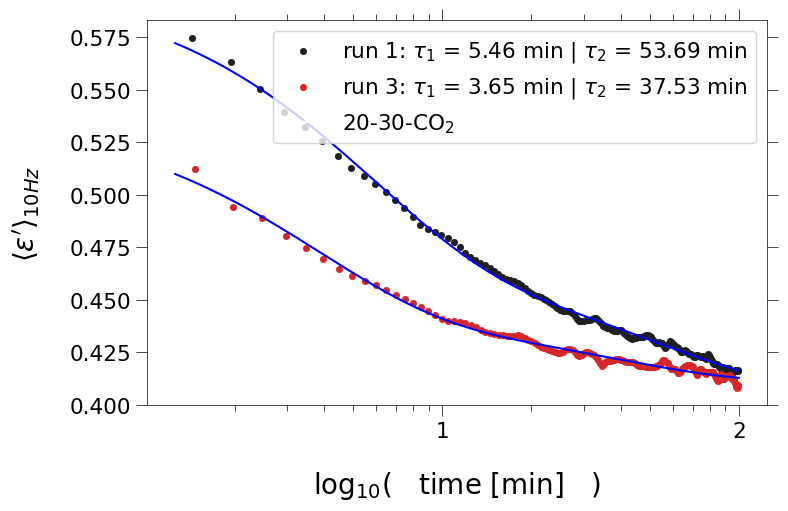

In [ ]:
### Plot area

title_text = "Fit area evolution of "

p01 = [
    [-3.3728, 0.861, 5.5448, 27.765, -1.6805],
    [-0.94137, 2.764, 2.9277, 32.179, -0.75788],
    [-0.75991, 4.9524, 2.1315, 69.878, -0.4908]]
p02 = [
    [1.2712, 3.2663, 1.4237, 61.509, 0.12305],
    [0.13294, 5.4554, 0.40669, 53.689, 0.06141],
    [0.13294, 5.4554, 0.40669, 53.689, 0.06141]]

t_fit = np.logspace(0.1, 2, 200)

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('log')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) or (id[0]=='3' and id[-1] in ['0', '2']) :
                continue
            label0 = "run " + id[-1]
            label_id = SAMPLE_SHORT + '-' + id[:-2]
            t, a = DT_ALL[j], A_ALL[j]
            fitt = (a < 100) & (t>1) & (t<100)
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                p0 = p01[T_i]
            else :
                p0 = p02[T_i]
            try :
                fitf = exp2
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, 20, i_, 2000, i_)))

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label0 + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                if tau2 > 500 :
                    fitf = exp
                    popt, _ = curve_fit(fitf, t, a, p0=p0[:3], bounds=((-i_, 0, 0.), (i_, i_, i_)))
                    tau2 = np.round(popt[1],2)
                    label = label0 + f': $\\tau_2$ = {tau2} min'


                print([round_sig(pi, 5) for pi in popt])
                plt.plot(t_fit, fitf(t_fit, *popt), color="b")

                #y1 = fitf(t_fit, 0, *popt[1:])
                #y2 = fitf(t_fit, *popt[:-1], 0)
                #plt.plot(t_fit, y1, color='yellow', ls=":")
                #plt.plot(t_fit, y2, color='green', ls=":")

            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)

        ax = plt.gca()
        ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
        plt.plot([],[],color='white',label=label_id)
        plt.xlabel("log$_{10}$(   time [min]   )")
        plt.ylabel("$\\langle\\varepsilon'\\rangle_{10Hz}$")
        plt.legend()
        #plt.savefig(results_folder + "/area/"+label_id+".pdf", bbox_inches='tight')
        plt.show()

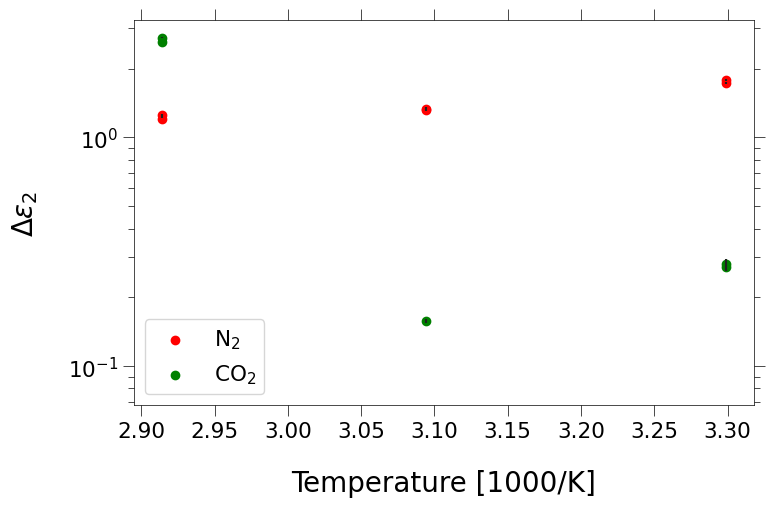

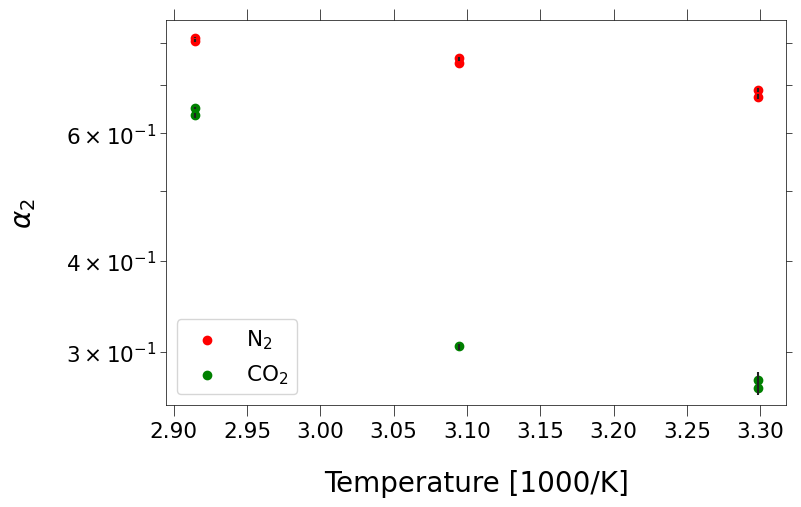

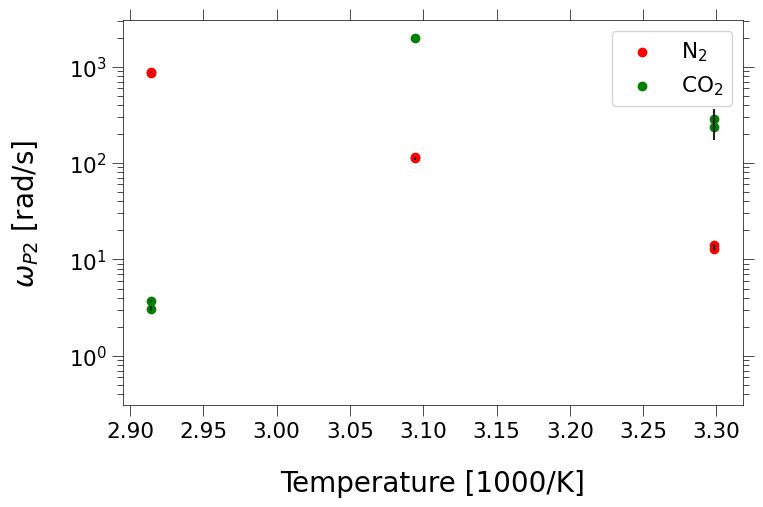

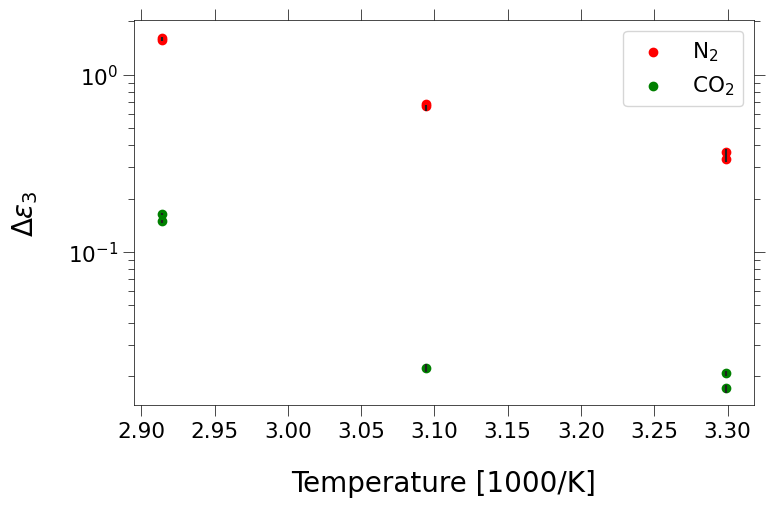

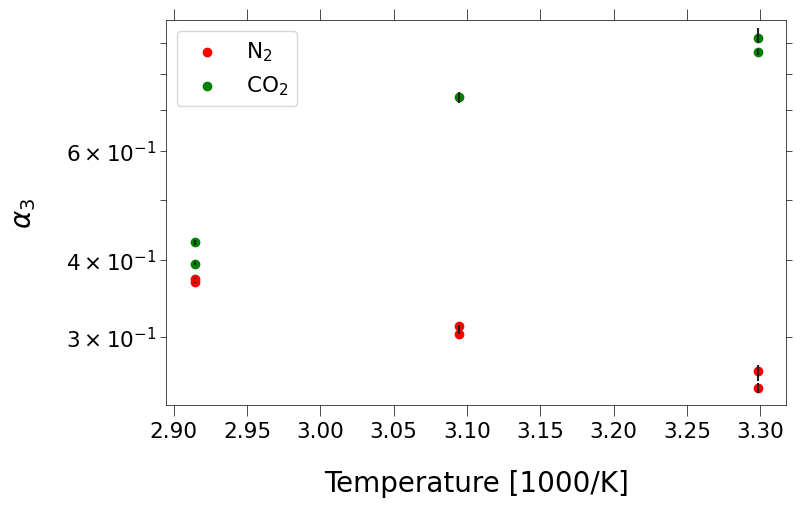

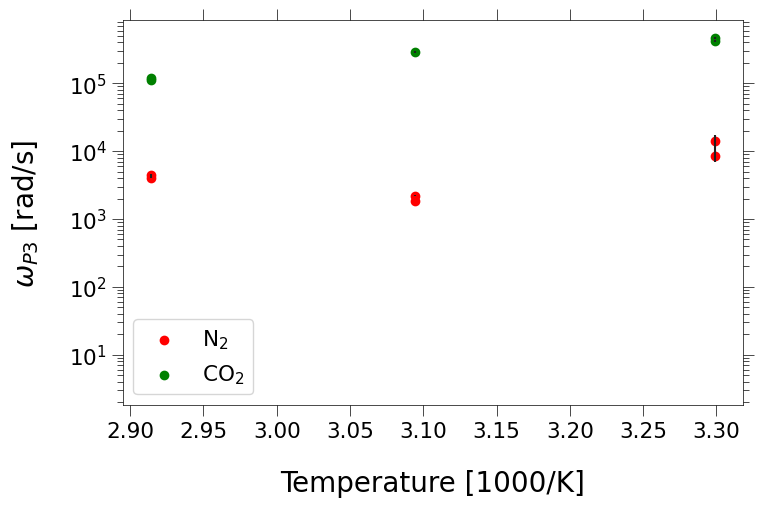

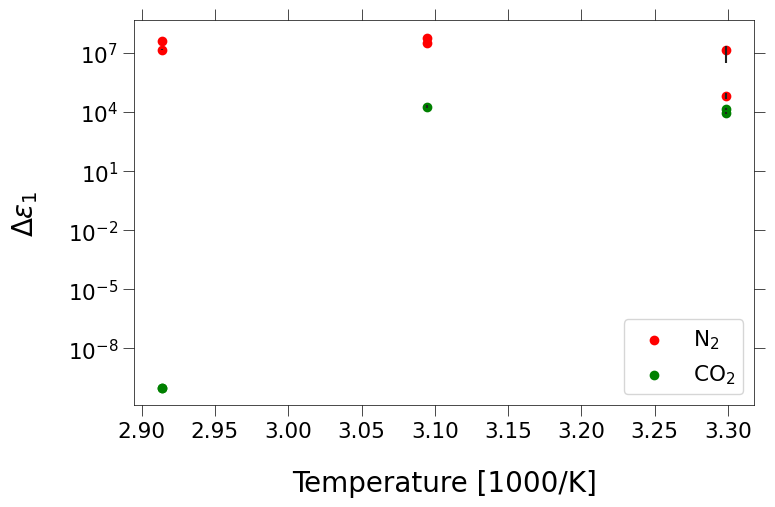

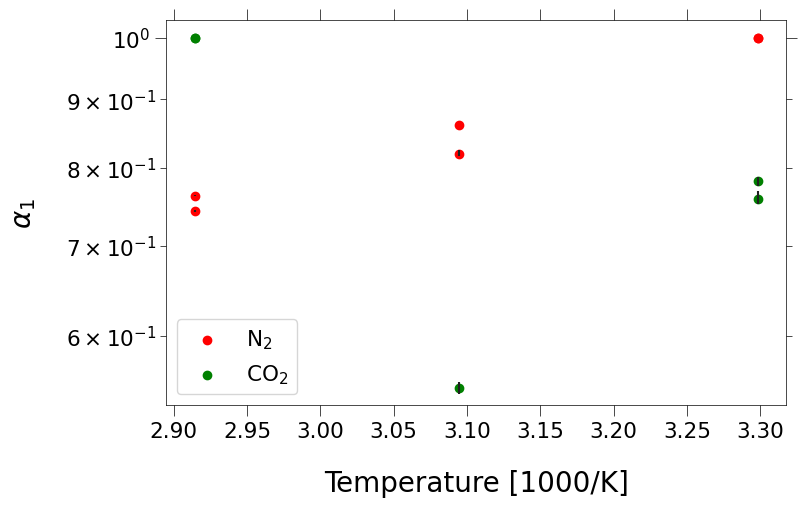

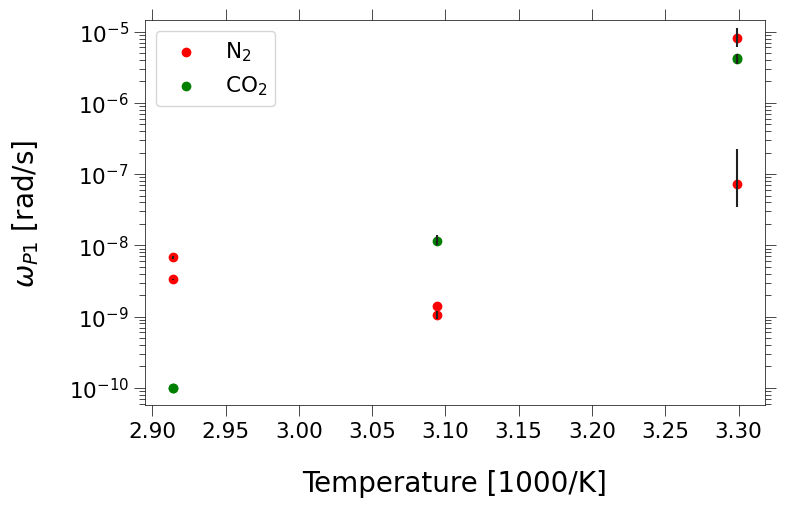

In [10]:
### plot final fit parameters against temperature
title = "Equilibrated fit parameter of " + SAMPLE
colors = ['red', 'green']

for i, p in enumerate(p_labels) :

    plt.yscale('log')

    for g_i, gas in enumerate(GASES) :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            end = DT_ALL_[j] > 100
            x = P_ALL_[j][i][end]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        T = 1000/(v[0]+273.15)
        plt.scatter(T, v[1], linewidths=2, label=gas, color=colors[g_i])
        plt.errorbar(T, v[1], yerr=v[2:], fmt='none')
        plt.xlabel("Temperature [1000/K]")#"$1/(\\epsilon_0 k_B T)$")

    #plt.title(title)
    plt.ylabel(p)
    plt.legend()
    #plt.savefig(results_folder + "/endval/"+p_file_labels[i]+".pdf", bbox_inches='tight')
    plt.show()
